# Long Text Classification --- Clinical-Bert-Model-512 + Heir

1.   List item
2.   List item



In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os

os.chdir("/content/drive/My Drive/MIMIC")
os.listdir("/content/drive/My Drive/MIMIC")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['Multi-Filter-Residual-Convolutional-Neural-Network',
 'LAAT',
 'LAAT_Run.ipynb',
 'Process_Data',
 'MResCNN_RUN.ipynb',
 'BERT_FineTune',
 'Transformer_MCP_1.ipynb',
 'Bert-Chinese-Text-Classification-Pytorch',
 'Transformer_MCP_3.ipynb',
 'caml-mimic',
 'MResCNN_RUN_2.ipynb',
 'CALM_RUN.ipynb',
 'Transformer_MCP_4.ipynb',
 'Transformer_MCP_2.ipynb',
 'FineTune_Visualization.ipynb',
 'mca_bert',
 'Does_Bert_Magic.ipynb',
 'Find_MN.ipynb',
 'transformersum',
 'Transformer_MCP_6_ClinicalBert + Heir.ipynb',
 'Transformer_MCP_7_longformer.ipynb',
 'Transformer_MCP_8_ClinicalBert512 + Heir.ipynb',
 'Transformer_MCP_5_Bert-based-model + Heir.ipynb',
 'Data_Augmentation_sub1.ipynb',
 'Data_Augmentation_sub3.ipynb',
 'Data_Augmentation_sub2.ipynb',
 'Data_Augmentation.ipynb',
 'Transformer_MCP_10_ClinicalBert512 + Heir + DataAug.ipynb',
 'Transformer_MCP_9_Bert-based-model + Heir + DataAug.ipynb']

In [2]:
#! pip install d2l
! pip install transformers
! pip install -U matplotlib
! pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import math
import torch
from torch import nn
import torch.nn.functional as F
#from d2l import torch as d2l

import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer,AutoTokenizer
from torch.utils.data import Dataset
import json

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,roc_auc_score,f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve,average_precision_score,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [4]:
# 产看配置
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  8 07:29:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Practice

In [5]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [6]:
'''
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
'''

'\nnum_hiddens, num_heads = 100, 5\nattention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,\n                               num_hiddens, num_heads, 0.5)\nattention.eval()\n'

In [7]:
'''
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape
'''

'\nbatch_size, num_queries = 2, 4\nnum_kvpairs, valid_lens =  6, torch.tensor([3, 2])\nX = torch.ones((batch_size, num_queries, num_hiddens))\nY = torch.ones((batch_size, num_kvpairs, num_hiddens))\nattention(X, Y, Y, valid_lens).shape\n'

In [8]:
######## Transformer Module #############################
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X,valid_lens):
        mid = self.attention(X, X, X,valid_lens)
        print('mid:',mid)
        Y = self.addnorm1(X, mid)
        return self.addnorm2(Y, self.ffn(Y))

In [9]:
'''X = torch.ones((2,4,768))
valid_lens = torch.tensor([100, 100])
encoder_blk = EncoderBlock(768, 768, 768, 768, [4,768], 768, 768*2, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape'''

'X = torch.ones((2,4,768))\nvalid_lens = torch.tensor([100, 100])\nencoder_blk = EncoderBlock(768, 768, 768, 768, [4,768], 768, 768*2, 8, 0.5)\nencoder_blk.eval()\nencoder_blk(X, valid_lens).shape'

In [10]:
'''X = torch.ones((2,4,768))
valid_lens = torch.tensor([0, 0])

encoder_blk.eval()
encoder_blk(X, valid_lens).shape'''

'X = torch.ones((2,4,768))\nvalid_lens = torch.tensor([0, 0])\n\nencoder_blk.eval()\nencoder_blk(X, valid_lens).shape'

In [11]:
import torch

In [12]:
'''
x = torch.tensor([0.0, 2.0, 8.0], requires_grad = True)
y = torch.tensor([5.0, 1.0, 7.0], requires_grad = True)
z = torch.tensor([[3.0, 4.0, 5.0]], requires_grad = True)
alpha = torch.tensor([33.0],requires_grad = True)

x_y_mul = x*y
x_y_mul_add = x_y_mul.unsqueeze(dim=0)
cat_x_y = torch.cat([x_y_mul_add,z],dim=0)
cat_x_y = cat_x_y.view(-1)

mul = cat_x_y * alpha
mul = mul.sum()
mul.backward()
print(x.grad)
print(y.grad)

print(x_y_mul.grad)
print(x_y_mul_add.grad)

print(z.grad)
print(cat_x_y.grad)

print(alpha.grad)
#z = x * y
#z.backward(torch.Tensor([1, 1, 1]))

#print(x.grad, y.grad)
# outputs
#(tensor([5., 1., 7.]), tensor([0., 2., 8.]))'''

'\nx = torch.tensor([0.0, 2.0, 8.0], requires_grad = True)\ny = torch.tensor([5.0, 1.0, 7.0], requires_grad = True)\nz = torch.tensor([[3.0, 4.0, 5.0]], requires_grad = True)\nalpha = torch.tensor([33.0],requires_grad = True)\n\nx_y_mul = x*y\nx_y_mul_add = x_y_mul.unsqueeze(dim=0)\ncat_x_y = torch.cat([x_y_mul_add,z],dim=0)\ncat_x_y = cat_x_y.view(-1)\n\nmul = cat_x_y * alpha\nmul = mul.sum()\nmul.backward()\nprint(x.grad)\nprint(y.grad)\n\nprint(x_y_mul.grad)\nprint(x_y_mul_add.grad)\n\nprint(z.grad)\nprint(cat_x_y.grad)\n\nprint(alpha.grad)\n#z = x * y\n#z.backward(torch.Tensor([1, 1, 1]))\n\n#print(x.grad, y.grad)\n# outputs\n#(tensor([5., 1., 7.]), tensor([0., 2., 8.]))'

In [13]:
#tensor1 = torch.tensor([[1,2],[3,4]])
#tensor2 = tensor1.unsqueeze(dim=1)
#print(tensor2.shape)
#tensor1.size()[0]

# Utils

In [14]:
# 自制数据集
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['text']
        self.targets = dataframe['labels']
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']  # 将 input 中的词 encode,把一句话变为一个一维的tensor, 向量长度为max-length, 如果文本过段，用0填充。
        mask = inputs['attention_mask']  # 用于 truncation
        token_type_ids = inputs["token_type_ids"]  # 第几句话
        return {
            'ids': torch.tensor(ids, dtype=torch.long),  # 数据 text ，经过encoder后的结果
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [15]:
# 加载模型
def load_ckp(checkpoint_fpath, model, optimizer):

    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training

    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min
# 保存模型
def save_ckp(state, checkpoint_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)


# Dataset

In [16]:
#################################### prepare data ###############################
# load raw data
train_data_pro = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/train_50_pro2.csv')
test_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/test_50.csv')
val_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/dev_50.csv')
test_data_pro = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/test_50_pro2.csv')

# 首先收集所有的 top 50 的标签，做成列表
top_50_list = []
top_50_code = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/TOP_50_CODES.csv',header=None)
idx2code = {0: '038.9', 1: '244.9', 2: '250.00', 3: '272.0', 4: '272.4', 5: '276.1', 6: '276.2', 7: '285.1', 8: '285.9', 9: '287.5', 10: '305.1', 11: '311', 12: '33.24', 13: '36.15', 14: '37.22', 15: '37.23', 16: '38.91', 17: '38.93', 18: '39.61', 19: '39.95', 20: '401.9', 
            21: '403.90', 22: '410.71', 23: '412', 24: '414.01', 25: '424.0', 26: '427.31', 27: '428.0', 28: '45.13', 29: '486', 30: '496', 31: '507.0', 32: '511.9', 33: '518.81', 34: '530.81', 35: '584.9', 36: '585.9', 37: '599.0', 38: '88.56', 39: '88.72', 40: '96.04', 
            41: '96.6', 42: '96.71', 43: '96.72', 44: '99.04', 45: '99.15', 46: '995.92', 47: 'V15.82', 48: 'V45.81', 49: 'V58.61'}
for index in range(len(top_50_code[0])):
  #raw_info = top_50_code.iloc[index]
  #top_50_list.append(raw_info[0])
  top_50_list.append(idx2code[index])

# 讲一条病人的数据，转化为向量
def data_2_label(data_text,top_50_list):
  label = []
  labels = data_text.split(';')
  for element in top_50_list:
    if element in labels:
      label.append(1)
    else:
      label.append(0)
  return label

# 制作训练集
train_data_list = []
for index in range(len(train_data_pro['LABELS'])):
  row_info = train_data_pro.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  train_data_list.append([text,labels])
  
train_data_pro_df = pd.DataFrame(train_data_list)
train_data_pro_df.columns = ["text", "labels"]

# 制作验证集
val_data_list = []
for index in range(len(val_data['LABELS'])):
  row_info = val_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  val_data_list.append([text,labels])
  
val_data_df = pd.DataFrame(val_data_list)
val_data_df.columns = ["text", "labels"]

# 制作测试集
test_data_list = []
for index in range(len(test_data['LABELS'])):
  row_info = test_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  test_data_list.append([text,labels])
  
test_data_df = pd.DataFrame(test_data_list)
test_data_df.columns = ["text", "labels"]

# 制作测试集pro
test_data_list = []
for index in range(len(test_data_pro['LABELS'])):
  row_info = test_data_pro.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  test_data_list.append([text,labels])
  
test_data_pro_df = pd.DataFrame(test_data_list)
test_data_pro_df.columns = ["text", "labels"]

In [17]:
print(len(train_data_pro_df),len(val_data_df),len(test_data_df),len(test_data_pro_df))

14510 1573 1729 1729


In [18]:
#数据集的参数
tokenizer = AutoTokenizer.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
MAX_LEN = 1500
batch_size = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# 准备数据集 
training_set = CustomDataset(train_data_pro_df, tokenizer, MAX_LEN)
val_set = CustomDataset(val_data_df, tokenizer, MAX_LEN)
test_set = CustomDataset(test_data_df, tokenizer, MAX_LEN)
test_pro_set = CustomDataset(test_data_pro_df, tokenizer, MAX_LEN)

# 把数据集做成 batch_size 的形式
train_iter = torch.utils.data.DataLoader(training_set, batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_set, batch_size)
test_iter = torch.utils.data.DataLoader(test_set, batch_size)
test_pro_iter = torch.utils.data.DataLoader(test_pro_set, batch_size)

# Model

In [19]:
######## Transformer Module #############################
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X,valid_lens):
        mid = self.attention(X, X, X,valid_lens)
        print('mid:',mid)
        Y = self.addnorm1(X, mid)
        return self.addnorm2(Y, self.ffn(Y))

In [20]:
# 微调 BERT 啥技巧也没有
'''
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]
        # 全连接层
        self.l3 = torch.nn.Dropout(0.2)
        self.l4 = torch.nn.Linear(768, 50)
        self.l5 = torch.nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        #print(ids.shape,mask.shape,token_type_ids.shape)
        output_all_bert1 = self.l1_bert1(ids[:,0:512*1], attention_mask = mask[:,0:512*1], token_type_ids = token_type_ids[:,0:512*1])
        output_bert1 = output_all_bert1[1] 
        
        # 进入全连接层
        output_l3 = self.l3(output_bert1)
        output_l4 = self.l4(output_l3)
        output_l5 = self.l5(output_l4)
        return output_l5
'''

"\nclass BERTClass(torch.nn.Module):\n    def __init__(self):\n        super(BERTClass, self).__init__()\n        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]\n        # 全连接层\n        self.l3 = torch.nn.Dropout(0.2)\n        self.l4 = torch.nn.Linear(768, 50)\n        self.l5 = torch.nn.Sigmoid()\n\n    def forward(self, ids, mask, token_type_ids):\n        #print(ids.shape,mask.shape,token_type_ids.shape)\n        output_all_bert1 = self.l1_bert1(ids[:,0:512*1], attention_mask = mask[:,0:512*1], token_type_ids = token_type_ids[:,0:512*1])\n        output_bert1 = output_all_bert1[1] \n        \n        # 进入全连接层\n        output_l3 = self.l3(output_bert1)\n        output_l4 = self.l4(output_l3)\n        output_l5 = self.l5(output_l4)\n        return output_l5\n"

In [21]:
# 微调 BERT
# 使用 Does Bert Magic ...? 论文里的架构

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]
        self.l1_bert2 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        self.l1_bert3 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        #self.l1_bert4 = transformers.BertModel.from_pretrained('bert-base-uncased')

        # concat 后 的大小为： [batch_size(4), 4 , num_hidden(768)]
        # transformer 层
        #self.l2 = d2l.EncoderBlock(768,768,768,768,
        #                       [3,768],
        #                       768,768*2,
        #                       8,0.3)
        encoder_layers = nn.TransformerEncoderLayer(d_model=768, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=2)
        # 全连接层
        self.l3 = torch.nn.Dropout(0.2)
        self.l4 = torch.nn.Linear(768, 50)
        self.l5 = torch.nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        #print(ids.shape,mask.shape,token_type_ids.shape)
        output_all_bert1 = self.l1_bert1(ids[:,0:512], attention_mask = mask[:,0:512], token_type_ids = token_type_ids[:,0:512])
        output_bert1 = output_all_bert1[0]  # output_all_bert1[1].unsqueeze(dim=1)
        output_all_bert2 = self.l1_bert2(ids[:,450:450+512], attention_mask = mask[:,450:450+512], token_type_ids = token_type_ids[:,450:450+512])
        output_bert2 = output_all_bert2[0]
        output_all_bert3 = self.l1_bert3(ids[:,900:900+512], attention_mask = mask[:,900:900+512], token_type_ids = token_type_ids[:,900:900+512])
        output_bert3 = output_all_bert3[0]
        #output_all_bert4 = self.l1_bert4(ids[:,512*3:512*4], attention_mask = mask[:,512*3:512*4], token_type_ids = token_type_ids[:,512*3:512*4])
        #output_bert4 = output_all_bert4[1].unsqueeze(dim=1)
        # 拼接4个BERT的结果
        output_l1 = torch.cat([output_bert1,output_bert2,output_bert3],dim=1)  # output_bert3,output_bert4
        #print('output_l1 shape: ',output_l1.shape)

        # 进入transformer层
        #valid_len = (torch.tensor([4.0]) * torch.ones(output_l1.size()[0])).to(device)
        #output_l2 = self.l2(output_l1,valid_len)
        #print('output_l2 shape:',output_l2.shape)
        #print(output_l2.shape)
        output_l1 = output_l1.permute(0,2,1)
        output_l1 = output_l1.permute(2,0,1)
        transformer_output = self.transformer_encoder(output_l1)
        transformer_output = transformer_output.permute(1,0,2)
        transformer_output = transformer_output.max(dim=1)[0]

        # 进入全连接层
        # output_l2_view = output_l2.view(output_l2.size()[0],-1)
        output_l3 = self.l3(transformer_output)
        output_l4 = self.l4(output_l3)
        output_l5 = self.l5(output_l4)
        return output_l5


In [22]:
# BERT + CNN 进行文本分类
'''
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]
        self.l1_bert2 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        self.l1_bert3 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        for param in self.l1_bert1.parameters():
            param.requires_grad = True
        for param in self.l1_bert2.parameters():
            param.requires_grad = True
        for param in self.l1_bert3.parameters():
            param.requires_grad = True
        # CNN 关键参数
        self.convs = nn.ModuleList([nn.Conv2d(1, 256, (k, 768)) for k in (2, 3, 4)])
        self.dropout = nn.Dropout(0.2)
        self.fc_cnn = nn.Linear(256 * 3, 50)
        self.sigmoid = torch.nn.Sigmoid()

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, ids, mask, token_type_ids):
        # 使用 3 个 BERT 读取文本
        output_all_bert1 = self.l1_bert1(ids[:,0:450*1], attention_mask = mask[:,0:450*1], token_type_ids = token_type_ids[:,0:450*1])
        output_bert1 = output_all_bert1[0]  # output_all_bert1[1].unsqueeze(dim=1)
        output_all_bert2 = self.l1_bert2(ids[:,450*1:450*2], attention_mask = mask[:,450*1:450*2], token_type_ids = token_type_ids[:,450*1:450*2])
        output_bert2 = output_all_bert2[0]
        output_all_bert3 = self.l1_bert3(ids[:,450*2:450*3], attention_mask = mask[:,450*2:450*3], token_type_ids = token_type_ids[:,450*2:450*3])
        output_bert3 = output_all_bert3[0]
        # 拼接 3 个BERT的结果
        output_l1 = torch.cat([output_bert1,output_bert2,output_bert3],dim=1)  # output_bert3,output_bert4
        #print('output_l1 shape: ',output_l1.shape)

        # 进入卷积层
        out = output_l1.unsqueeze(1)  #[batch_size, 1, sequence_length, hiden_dimmension]
        out = torch.cat([self.conv_and_pool(out, conv) for conv in self.convs], 1)
        out = self.dropout(out)
        out = self.fc_cnn(out)
        out = self.sigmoid(out)
        return out
'''

"\nclass BERTClass(torch.nn.Module):\n    def __init__(self):\n        super(BERTClass, self).__init__()\n        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]\n        self.l1_bert2 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')\n        self.l1_bert3 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')\n        for param in self.l1_bert1.parameters():\n            param.requires_grad = True\n        for param in self.l1_bert2.parameters():\n            param.requires_grad = True\n        for param in self.l1_bert3.parameters():\n            param.requires_grad = True\n        # CNN 关键参数\n        self.convs = nn.ModuleList([nn.Conv2d(1, 256, (k, 768)) for k in (2, 3, 4)])\n        self.dropout = nn.Dropout(0.2)\n        self.fc_cnn = nn.Linear(256 * 3, 50)\n        self.sigmoid = torch.nn.Sigmoid()\n\n    def conv_and_pool(self, x,

In [23]:
# 3 BERT + DPCNN 深度金字塔卷积
'''
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # 加载 BERT 
        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]
        self.l1_bert2 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        self.l1_bert3 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
        for param in self.l1_bert1.parameters():
            param.requires_grad = True
        for param in self.l1_bert2.parameters():
            param.requires_grad = True
        for param in self.l1_bert3.parameters():
            param.requires_grad = True
        
        # self.fc = nn.Linear(config.hidden_size, config.num_classes)
        self.conv_region = nn.Conv2d(1, 250, (3, 768), stride=1)
        self.conv = nn.Conv2d(250, 250, (3, 1), stride=1)
        self.max_pool = nn.MaxPool2d(kernel_size=(3, 1), stride=2)
        self.padding1 = nn.ZeroPad2d((0, 0, 1, 1))  # top bottom
        self.padding2 = nn.ZeroPad2d((0, 0, 0, 1))  # bottom
        self.relu = nn.ReLU()
        self.fc = nn.Linear(250*2, 50)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        # 使用 3 个 BERT 读取文本
        output_all_bert1 = self.l1_bert1(ids[:,0:512*1], attention_mask = mask[:,0:512*1], token_type_ids = token_type_ids[:,0:512*1])
        output_bert1 = output_all_bert1[0]  # output_all_bert1[1].unsqueeze(dim=1)
        output_all_bert2 = self.l1_bert2(ids[:,512*1:512*2], attention_mask = mask[:,512*1:512*2], token_type_ids = token_type_ids[:,512*1:512*2])
        output_bert2 = output_all_bert2[0]
        output_all_bert3 = self.l1_bert3(ids[:,512*2:512*3], attention_mask = mask[:,512*2:512*3], token_type_ids = token_type_ids[:,512*2:512*3])
        output_bert3 = output_all_bert3[0]
        # 拼接 3 个BERT的结果
        output_l1 = torch.cat([output_bert1,output_bert2,output_bert3],dim=1)  # output_bert3,output_bert4
      
        # 进入 DPCNN 卷积层        
        x = output_l1.unsqueeze(1)  # [batch_size, 1, seq_len, embed]
        x = self.conv_region(x)  # [batch_size, 250, seq_len-3+1, 1]

        x = self.padding1(x)  # [batch_size, 250, seq_len, 1]
        x = self.relu(x)
        x = self.conv(x)  # [batch_size, 250, seq_len-3+1, 1]
        x = self.padding1(x)  # [batch_size, 250, seq_len, 1]
        x = self.relu(x)
        x = self.conv(x)  # [batch_size, 250, seq_len-3+1, 1]
        while x.size()[2] > 2:
            x = self._block(x)
        x = x.view(x.size()[0],-1)  # [batch_size, num_filters(250)*2]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    def _block(self, x):
        x = self.padding2(x)
        px = self.max_pool(x)
        x = self.padding1(px)
        x = F.relu(x)
        x = self.conv(x)
        x = self.padding1(x)
        x = F.relu(x)
        x = self.conv(x)
        x = x + px  # short cut
        return x
'''

"\nclass BERTClass(nn.Module):\n    def __init__(self):\n        super(BERTClass, self).__init__()\n        # 加载 BERT \n        self.l1_bert1 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')  # output [ batch_size(自己定) , num_hidden(768) ]\n        self.l1_bert2 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')\n        self.l1_bert3 = transformers.BertModel.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')\n        for param in self.l1_bert1.parameters():\n            param.requires_grad = True\n        for param in self.l1_bert2.parameters():\n            param.requires_grad = True\n        for param in self.l1_bert3.parameters():\n            param.requires_grad = True\n        \n        # self.fc = nn.Linear(config.hidden_size, config.num_classes)\n        self.conv_region = nn.Conv2d(1, 250, (3, 768), stride=1)\n        self.conv = nn.Conv2d(250, 250, (3, 1), stride=1)\n        self.max_pool = nn.MaxPool2d(kernel_siz

In [24]:
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at Emran/ClinicalBERT_ICD10_Categories were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at Emran/ClinicalBERT_ICD10_Categories were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

BERTClass(
  (l1_bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

# 优化器

In [25]:
import math
import torch
from torch.optim import Optimizer
from torch.optim.optimizer import required
from torch.nn.utils import clip_grad_norm_
import logging
import abc
import sys

logger = logging.getLogger(__name__)


if sys.version_info >= (3, 4):
    ABC = abc.ABC
else:
    ABC = abc.ABCMeta('ABC', (), {})


class _LRSchedule(ABC):
    """ Parent of all LRSchedules here. """
    warn_t_total = False        # is set to True for schedules where progressing beyond t_total steps doesn't make sense
    def __init__(self, warmup=0.002, t_total=-1, **kw):
        """
        :param warmup:  what fraction of t_total steps will be used for linear warmup
        :param t_total: how many training steps (updates) are planned
        :param kw:
        """
        super(_LRSchedule, self).__init__(**kw)
        if t_total < 0:
            logger.warning("t_total value of {} results in schedule not being applied".format(t_total))
        if not 0.0 <= warmup < 1.0 and not warmup == -1:
            raise ValueError("Invalid warmup: {} - should be in [0.0, 1.0[ or -1".format(warmup))
        warmup = max(warmup, 0.)
        self.warmup, self.t_total = float(warmup), float(t_total)
        self.warned_for_t_total_at_progress = -1

    def get_lr(self, step, nowarn=False):
        """
        :param step:    which of t_total steps we're on
        :param nowarn:  set to True to suppress warning regarding training beyond specified 't_total' steps
        :return:        learning rate multiplier for current update
        """
        if self.t_total < 0:
            return 1.
        progress = float(step) / self.t_total
        ret = self.get_lr_(progress)
        # warning for exceeding t_total (only active with warmup_linear
        if not nowarn and self.warn_t_total and progress > 1. and progress > self.warned_for_t_total_at_progress:
            logger.warning(
                "Training beyond specified 't_total'. Learning rate multiplier set to {}. Please set 't_total' of {} correctly."
                    .format(ret, self.__class__.__name__))
            self.warned_for_t_total_at_progress = progress
        # end warning
        return ret

    def get_lr_(self, progress):
        """
        :param progress:    value between 0 and 1 (unless going beyond t_total steps) specifying training progress
        :return:            learning rate multiplier for current update
        """
        return 1.


class ConstantLR(_LRSchedule):
    def get_lr_(self, progress):
        return 1.


class WarmupCosineSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Decreases learning rate from 1. to 0. over remaining `1 - warmup` steps following a cosine curve.
    If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    warn_t_total = True
    def __init__(self, warmup=0.002, t_total=-1, cycles=.5, **kw):
        """
        :param warmup:      see LRSchedule
        :param t_total:     see LRSchedule
        :param cycles:      number of cycles. Default: 0.5, corresponding to cosine decay from 1. at progress==warmup and 0 at progress==1.
        :param kw:
        """
        super(WarmupCosineSchedule, self).__init__(warmup=warmup, t_total=t_total, **kw)
        self.cycles = cycles

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)   # progress after warmup
            return 0.5 * (1. + math.cos(math.pi * self.cycles * 2 * progress))


class WarmupCosineWithHardRestartsSchedule(WarmupCosineSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    If `cycles` (default=1.) is different from default, learning rate follows `cycles` times a cosine decaying
    learning rate (with hard restarts).
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        super(WarmupCosineWithHardRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)
        assert(cycles >= 1.)

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * ((self.cycles * progress) % 1)))
            return ret


class WarmupCosineWithWarmupRestartsSchedule(WarmupCosineWithHardRestartsSchedule):
    """
    All training progress is divided in `cycles` (default=1.) parts of equal length.
    Every part follows a schedule with the first `warmup` fraction of the training steps linearly increasing from 0. to 1.,
    followed by a learning rate decreasing from 1. to 0. following a cosine curve.
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        assert(warmup * cycles < 1.)
        warmup = warmup * cycles if warmup >= 0 else warmup
        super(WarmupCosineWithWarmupRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)

    def get_lr_(self, progress):
        progress = progress * self.cycles % 1.
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * progress))
            return ret


class WarmupConstantSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Keeps learning rate equal to 1. after warmup.
    """
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return 1.


class WarmupLinearSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Linearly decreases learning rate from 1. to 0. over remaining `1 - warmup` steps.
    """
    warn_t_total = True
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return max((progress - 1.) / (self.warmup - 1.), 0.)


SCHEDULES = {
    None:       ConstantLR,
    "none":     ConstantLR,
    "warmup_cosine": WarmupCosineSchedule,
    "warmup_constant": WarmupConstantSchedule,
    "warmup_linear": WarmupLinearSchedule
}


class BertAdam(Optimizer):
    """Implements BERT version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1  means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate of 1. (no warmup regardless of warmup setting). Default: -1
        schedule: schedule to use for the warmup (see above).
            Can be `'warmup_linear'`, `'warmup_constant'`, `'warmup_cosine'`, `'none'`, `None` or a `_LRSchedule` object (see below).
            If `None` or `'none'`, learning rate is always kept constant.
            Default : `'warmup_linear'`
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """
    def __init__(self, params, lr=required, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-6, weight_decay=0.01, max_grad_norm=1.0, **kwargs):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not isinstance(schedule, _LRSchedule) and schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not e >= 0.0:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(e))
        # initialize schedule object
        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning("warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                               "Please specify custom warmup and t_total in _LRSchedule object.")
        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm)
        super(BertAdam, self).__init__(params, defaults)

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['next_m'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['next_v'] = torch.zeros_like(p.data)

                next_m, next_v = state['next_m'], state['next_v']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                next_m.mul_(beta1).add_(1 - beta1, grad)
                next_v.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                update = next_m / (next_v.sqrt() + group['e'])

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                if group['weight_decay'] > 0.0:
                    update += group['weight_decay'] * p.data

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])

                update_with_lr = lr_scheduled * update
                p.data.add_(-update_with_lr)

                state['step'] += 1

                # step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1
                # No bias correction
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']

        return loss

# Train 

In [26]:
import sys
import numpy as np
sys.path.append("/content/drive/My Drive/MIMIC/caml-mimic")  # 注意，这里改变了地址了
import evaluation

In [27]:
def get_roc_auc(val_targets,val_outputs):
  # input : val_targets 标签 ； val_outputs 模型的输出 (需要np.array类型)
  # output: return_fpr (micro,macro) , return_tpr (micro,macro) (list)
  # output: return_roc_auc (micro,macro)  (float)
  # Compute ROC curve and ROC area for each class
  n_classes = len(val_targets[0]) # [num_example,num_class] 
  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(n_classes):
    fpr_, tpr_, _ = roc_curve(val_targets[:, i], val_outputs[:, i])
    fpr[i] = fpr_.tolist()
    tpr[i] = tpr_.tolist()
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr_, tpr_, _ = roc_curve(val_targets.ravel(), val_outputs.ravel())
  fpr['micro'] = fpr_.tolist()
  tpr['micro'] = tpr_.tolist()
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= n_classes
  fpr["macro"] = all_fpr.tolist()
  tpr["macro"] = mean_tpr.tolist()
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # 返回时，我们只需要micro,macro的信息即可
  return_fpr = {'macro':fpr['macro'],'micro':fpr['micro']}
  return_tpr = {'macro':tpr['macro'],'micro':tpr['micro']}
  return_roc_auc = {'macro':roc_auc['macro'],'micro':roc_auc['micro']}
  return return_fpr,return_tpr,return_roc_auc

def epoch_perform(y_target,y_output):
  # 计算 prediction , 以 0.5 作为阈值
  # 输出 mretics
  '''
  'acc_macro','prec_macro','rec_macro','f1_macro'
  'acc_micro','prec_micro','rec_micro','f1_micro',
  'rec_at_5','prec_at_5', 'f1_at_5' , 
  'auc_macro','auc_micro','auc',
  'tpr','fpr',
  'prec_micro_curve','rec_micro,curve','ave_prec_micro'
  '''
  y_output = torch.tensor(y_output)
  ones = torch.ones_like(y_output)
  zeros = torch.zeros_like(y_output)
  y_prediction = torch.where(y_output > 0.5 , ones , zeros)
  y_output = y_output.cpu().detach().numpy()
  #print()
  #print('The evluation from other code:')
  metrics = evaluation.all_metrics(y_prediction.numpy(), y_target, k=5, yhat_raw= y_output)
  print(evaluation.print_metrics(metrics))
  # 计算 tpr ,fpr, 用于画出 ROC_AUCROC_AUC
  fpr,tpr,roc_auc = get_roc_auc(y_target,y_output)
  metrics['auc'] = roc_auc
  metrics['fpr'] = fpr
  metrics['tpr'] = tpr
  print(metrics['auc'])
  print()
  # 计算 precision,recall ,用于画出 precision-recall curve
  precision ={}
  recall = {}
  average_precision = {}
  metrics['prec_micro_curve'], metrics['rec_micro,curve'], _ = precision_recall_curve(y_target.ravel(), y_output.ravel())
  metrics['ave_prec_micro'] = average_precision_score(y_target, y_output, average="micro")
  return metrics

'''
def get_f1_pre_re(y_target,y_output):
  # 计算 F1 ， precision , recall
  y_output = torch.tensor(y_output)
  ones = torch.ones_like(y_output)
  zeros = torch.zeros_like(y_output)
  y_prediction = torch.where(y_output > 0.5 , ones , zeros)
  # 为了与其他的模型比较效果，我们放弃直接使用skearn的函数，转而使用其他的函数
  result['f1 micro'] = f1_score(y_target, y_prediction, average='micro')
  result['f1 macro'] = f1_score(y_target, y_prediction, average='macro')
  result['precision micro'] = precision_score(y_target, y_prediction, average='micro')
  result['precision macro'] = precision_score(y_target, y_prediction, average='macro')
  result['recall micro'] = recall_score(y_target, y_prediction, average='micro')
  result['recall macro'] = recall_score(y_target, y_prediction, average='macro')
  print()
  print('The evluation from other code:')
  metrics = evaluation.all_metrics(y_prediction, y_target, k=5, yhat_raw= y_output)
  print(evaluation.print_metrics(metrics))
  
  'acc_macro','prec_macro','rec_macro','f1_macro'
  'acc_micro','prec_micro','rec_micro','f1_micro',
  'rec_at_5','prec_at_5', 'f1_at_5' , 
  'auc_macro','auc_micro'
  
  return metrics


def epoch_perform(targets,outputs,name):
  performence = get_f1_pre_re(targets,outputs)
  fpr,tpr,roc_auc = get_roc_auc(targets,outputs)
  performence['auc'] = roc_auc
  performence['fpr'] = fpr
  performence['tpr'] = tpr
  print()
  print(name+' performence:')
  print('auc(micro): ',roc_auc['micro'],'\tauc(macro):',roc_auc['macro'])
  print('precision(micro):',performence['precision micro'],
        '\tprecison(macro):',performence['precision macro'],
        '\trecall(micro):',performence['recall micro'],
        '\trecall(macro):',performence['recall macro'],
        '\tf_1 (micro):',performence['f1 micro'],
        '\tf_1 (macro):',performence['f1 macro'])
  return performence
'''

"\ndef get_f1_pre_re(y_target,y_output):\n  # 计算 F1 ， precision , recall\n  y_output = torch.tensor(y_output)\n  ones = torch.ones_like(y_output)\n  zeros = torch.zeros_like(y_output)\n  y_prediction = torch.where(y_output > 0.5 , ones , zeros)\n  # 为了与其他的模型比较效果，我们放弃直接使用skearn的函数，转而使用其他的函数\n  result['f1 micro'] = f1_score(y_target, y_prediction, average='micro')\n  result['f1 macro'] = f1_score(y_target, y_prediction, average='macro')\n  result['precision micro'] = precision_score(y_target, y_prediction, average='micro')\n  result['precision macro'] = precision_score(y_target, y_prediction, average='macro')\n  result['recall micro'] = recall_score(y_target, y_prediction, average='micro')\n  result['recall macro'] = recall_score(y_target, y_prediction, average='macro')\n  print()\n  print('The evluation from other code:')\n  metrics = evaluation.all_metrics(y_prediction, y_target, k=5, yhat_raw= y_output)\n  print(evaluation.print_metrics(metrics))\n  \n  'acc_macro','prec_macro','rec_m

In [28]:
def draw_pr_roc(test_performence,
                y_target,y_output,
                save_path,epoch,name,
                key):
  # fpr, tpr,roc_auc 三个字典，是 get_roc_auc的输出
  # y_target 标签 ； y_output 模型的输出
  # save_path 保存图片的地址 ； epoch,name 记录是哪一次的信息
  # 输出： 两张图表，roc曲线 和 precision_recall曲线
  # 画图，首先是左边，roc_auc 曲线
  fig, axs = plt.subplots(1, 2, figsize=(21, 10))
  axs[0].step(
      test_performence['fpr']["micro"],
      test_performence['tpr']["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(test_performence['auc']["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  axs[0].step(
      test_performence['fpr']["macro"],
      test_performence['tpr']["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(test_performence['auc']["macro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,
    ) 
  axs[0].plot([0, 1], [0, 1], "k--", lw=2)
  axs[0].set_xlim([0.0, 1.0])
  axs[0].set_ylim([0.0, 1.05])
  axs[0].set_xlabel("False Positive Rate")
  axs[0].set_ylabel("True Positive Rate")
  axs[0].set_title("Receiver Operating Characteristic to multiclass")

  # 然后是右边，precision_recall curve
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines, labels = [], []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      (l,) = axs[1].plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
      axs[1].annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

  display = PrecisionRecallDisplay(
      recall=test_performence['rec_micro,curve'],
      precision=test_performence['prec_micro_curve'],
      average_precision = test_performence['prec_micro'],
  )
  display.plot(ax=axs[1], name="Micro-average precision-recall", 
               color="#f97306",linewidth=2) 

  # add the legend for the iso-f1 curves
  handles, labels = display.ax_.get_legend_handles_labels()
  handles.extend([l])
  labels.extend(["iso-f1 curves"])
  # set the legend and the axes
  axs[1].set_xlim([0.0, 1.0])
  axs[1].set_ylim([0.0, 1.05])
  axs[1].legend(handles=handles, labels=labels, loc="best")
  axs[1].set_title("Micro-averaged Prcision-Recall Line")

  for ax in axs:
    ax.legend(loc="lower right")
  plt.show()
  if key == 1:
    fig.savefig(fname =save_path+'/epoch_'+str(epoch)+'_'+name+'.png')

#draw_pr_roc(return_fpr,return_tpr,return_roc_auc,Y,y_score,
#            save_path='/content/drive/My Drive/MIMIC',epoch=1,name='val')

In [29]:
def draw_loss(result_loss,save_path,key):
  fig, axs = plt.subplots(2, 3, figsize=(24, 16))
  # 可视化 train_loss_batch
  x = np.arange(0,len(result_loss['train_loss_batch']),1)
  y = np.array(result_loss['train_loss_batch'])
  axs[0][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[0][0].set_xlim([0.0, 1.0])
  #axs[0][0].set_ylim([0.0, 1.05])
  axs[0][0].set_xlabel("epoch")
  axs[0][0].set_ylabel("Loss")
  axs[0][0].set_title("Train Loss per Batchs")
  
  # 可视化 train_loss_epoch
  x = np.arange(0,len(result_loss['train_loss_epoch']),1)
  y = np.array(result_loss['train_loss_epoch'])
  print(x)
  print(y)
  axs[0][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[0][1].set_xlim([0.0, 1.0])
  #axs[0][1].set_ylim([0.0, 1.05])
  axs[0][1].set_xlabel("epoch")
  axs[0][1].set_ylabel("Loss")
  axs[0][1].set_title("Train Loss per Epoch")
  
  # 可视化 test_loss_epoch
  x = np.arange(0,len(result_loss['test_loss_epoch']),1)
  y = np.array(result_loss['test_loss_epoch'])
  axs[0][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[1][0].set_xlim([0.0, 1.0])
  #axs[1][0].set_ylim([0.0, 1.05])
  axs[0][2].set_xlabel("epoch")
  axs[0][2].set_ylabel("Loss")
  axs[0][2].set_title("Test Loss per Epoch")
  
  # 可视化 F 1
  x = np.arange(0,len(result_loss['test_macro_f1']),1)
  y = np.array(result_loss['test_macro_f1'])
  axs[1][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "F1(macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_f1']),1)
  y = np.array(result_loss['test_micro_f1'])
  axs[1][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "F1(micro)",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][0].set_xlabel("epoch")
  axs[1][0].set_ylabel("F 1 score")
  axs[1][0].set_title("F 1 score per Epoch")
  axs[1][0].legend()

  # 可视化 AUC 得分
  x = np.arange(0,len(result_loss['test_macro_auc']),1)
  y = np.array(result_loss['test_macro_auc'])
  axs[1][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "auc (macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_auc']),1)
  y = np.array(result_loss['test_micro_auc'])
  axs[1][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      label = "auc (micro)",
      #linestyle=":",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][1].set_xlabel("epoch")
  axs[1][1].set_ylabel("AUC Score")
  axs[1][1].set_title("AUC score per Epoch")
  axs[1][1].legend()
  # 可视化 Precision
  x = np.arange(0,len(result_loss['test_macro_precision']),1)
  y = np.array(result_loss['test_macro_precision'])
  axs[1][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "Precision (macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_precision']),1)
  y = np.array(result_loss['test_micro_precision'])
  axs[1][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "Precision (micro)",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][2].set_xlabel("epoch")
  axs[1][2].set_ylabel("Precision score")
  axs[1][2].set_title("Precision score per Epoch")
  axs[1][2].legend()
  plt.show()
  if key == 1:
    fig.savefig(fname =save_path+'/loss_epoch_'+str(epoch)+'.png')


In [30]:
# 设置参数
checkpoint_path = '/content/drive/My Drive/MIMIC/BERT_FineTune/clinical_bert_512_heir/3Bert+stransformer+DA'
model_name = 'clinical-bert-512-heir-transformer-DA'

LEARNING_RATE = 2e-05

start_epochs = 1
n_epochs = 12

# 损失函数
def loss_fn(outputs, targets):
    #return torch.nn.functional.cross_entropy(outputs, targets)
    return torch.nn.functional.binary_cross_entropy(outputs,targets)

# 优化器，使用 warm up ,  AdmaW
# optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

#optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=LEARNING_RATE,
#                      warmup=0.05,
#                      t_total=len(train_iter) * n_epochs)
#sigmoid = torch.nn.Sigmoid()

###############   Epoch 1: Training Start   #############
already deal with 600 data 	loss: 0.5292260646820068
already deal with 1200 data 	loss: 0.31381547451019287
already deal with 1800 data 	loss: 0.34017214179039
already deal with 2400 data 	loss: 0.2329825460910797
already deal with 3000 data 	loss: 0.31507790088653564
already deal with 3600 data 	loss: 0.41893407702445984
already deal with 4200 data 	loss: 0.2783214747905731
already deal with 4800 data 	loss: 0.31995630264282227
already deal with 5400 data 	loss: 0.2732473313808441
already deal with 6000 data 	loss: 0.25270718336105347
already deal with 6600 data 	loss: 0.27938953042030334
already deal with 7200 data 	loss: 0.30604127049446106
already deal with 7800 data 	loss: 0.18175660073757172
already deal with 8400 data 	loss: 0.38835835456848145
already deal with 9000 data 	loss: 0.3629433810710907
already deal with 9600 data 	loss: 0.3851070702075958
already deal with 10200 data 	loss: 0.2738592028617859
already deal with

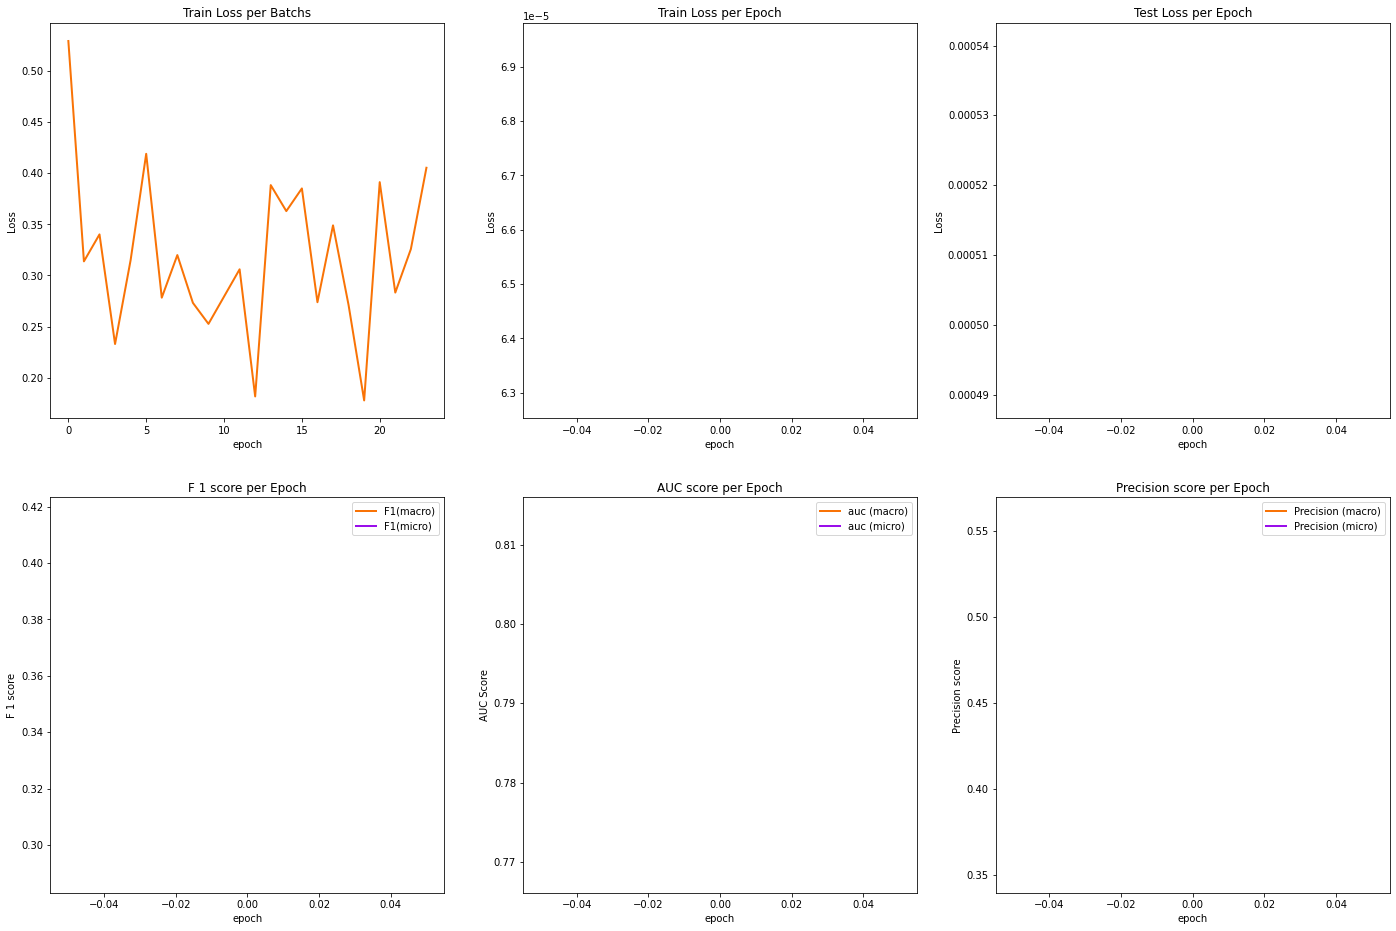

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996], 'train_loss_epoch': [6.616700013745067e-05], 'test_loss_epoch': [0.0005122608084043937], 'test_macro_f1': [0.3006688750456558], 'test_macro_recall': [0.2531194751716419], 'test_macro_precision': [0.37021510909026034], 'test_micro_f1': [0.4180676039485492], 'test_micro_recall': [0.3334924119499857], 'test_micro_precision': [0.5601154216094902], 'test_macro_auc': [0.7702477529716725], 'test_micro_auc': [0.8154367423004593]}
[0]
[6.61670001e-05]


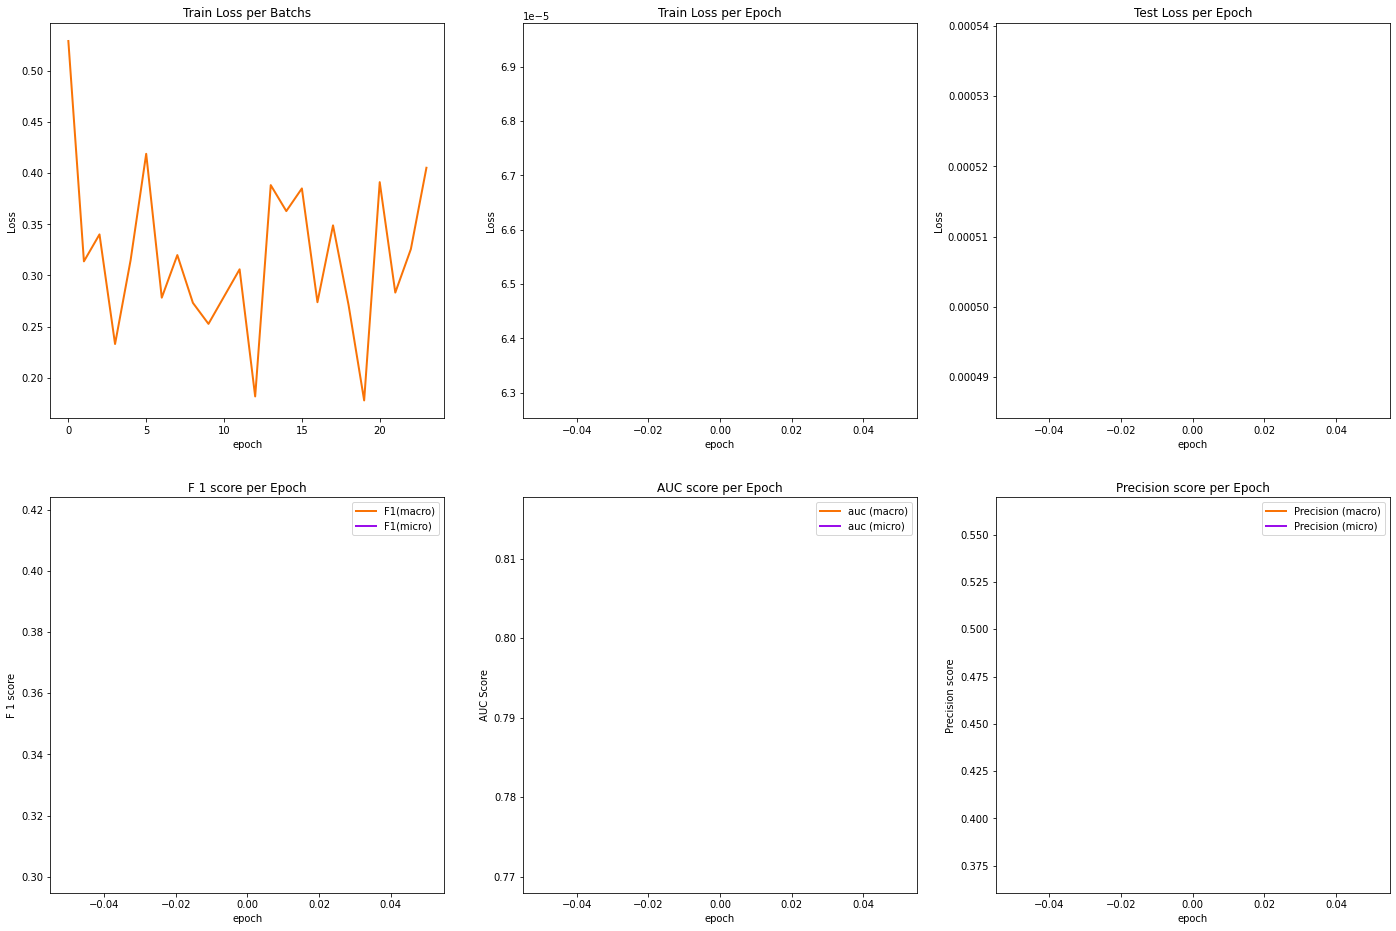

#########  Visulization End :##########
###############   Epoch 2: Training Start   #############
already deal with 600 data 	loss: 0.19935233891010284
already deal with 1200 data 	loss: 0.21396228671073914
already deal with 1800 data 	loss: 0.32650575041770935
already deal with 2400 data 	loss: 0.28349024057388306
already deal with 3000 data 	loss: 0.11000818014144897
already deal with 3600 data 	loss: 0.30701103806495667
already deal with 4200 data 	loss: 0.2595480680465698
already deal with 4800 data 	loss: 0.24953024089336395
already deal with 5400 data 	loss: 0.16944493353366852
already deal with 6000 data 	loss: 0.26336491107940674
already deal with 6600 data 	loss: 0.2461409568786621
already deal with 7200 data 	loss: 0.3509643077850342
already deal with 7800 data 	loss: 0.3618558645248413
already deal with 8400 data 	loss: 0.17641885578632355
already deal with 9000 data 	loss: 0.3493410348892212
already deal with 9600 data 	loss: 0.20438331365585327
already deal with 10200 data

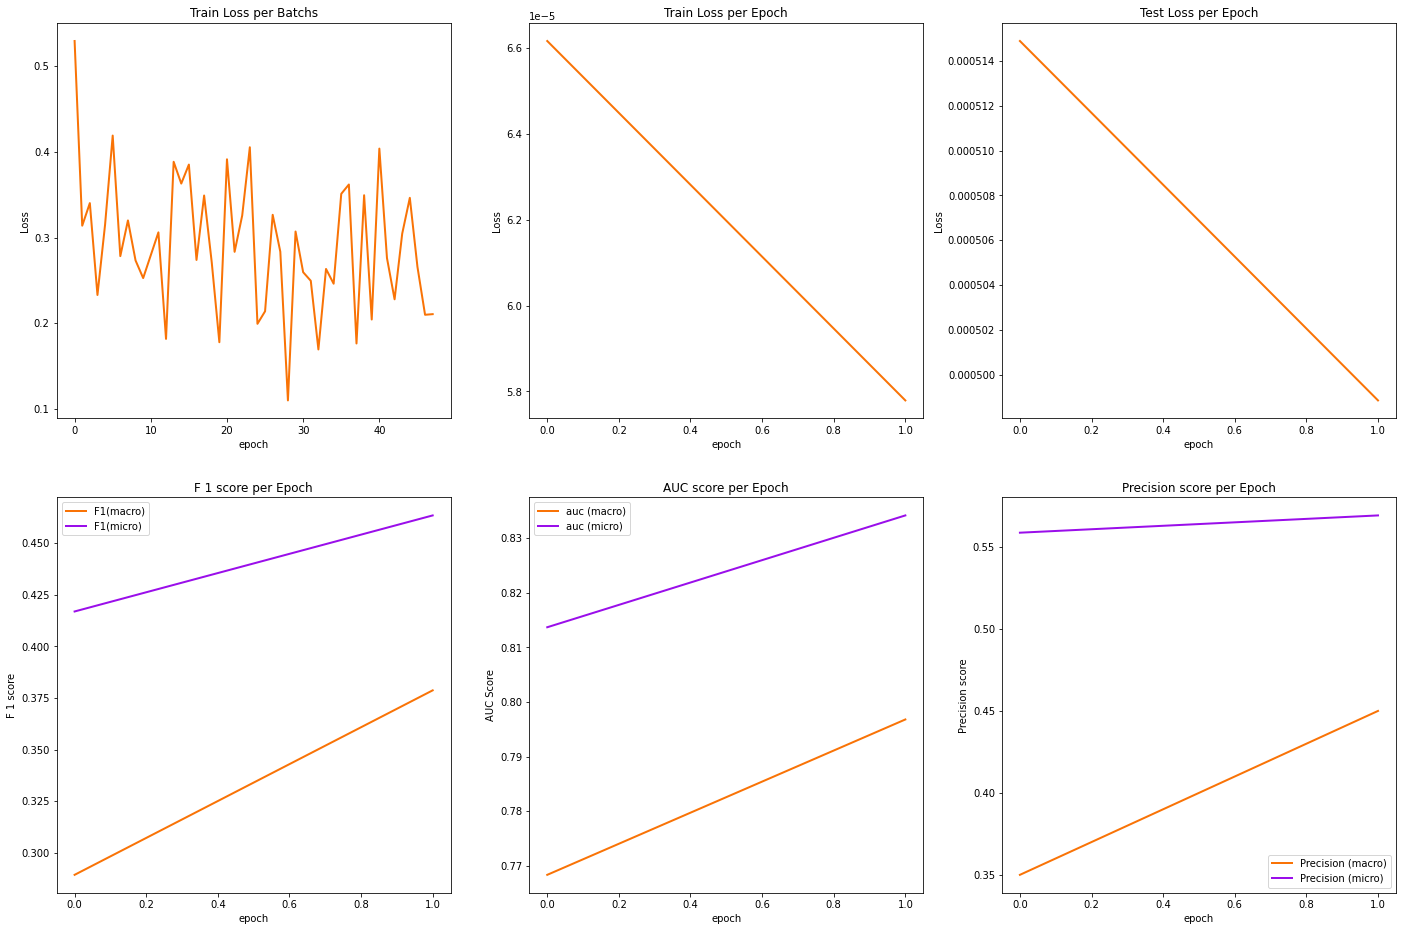

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

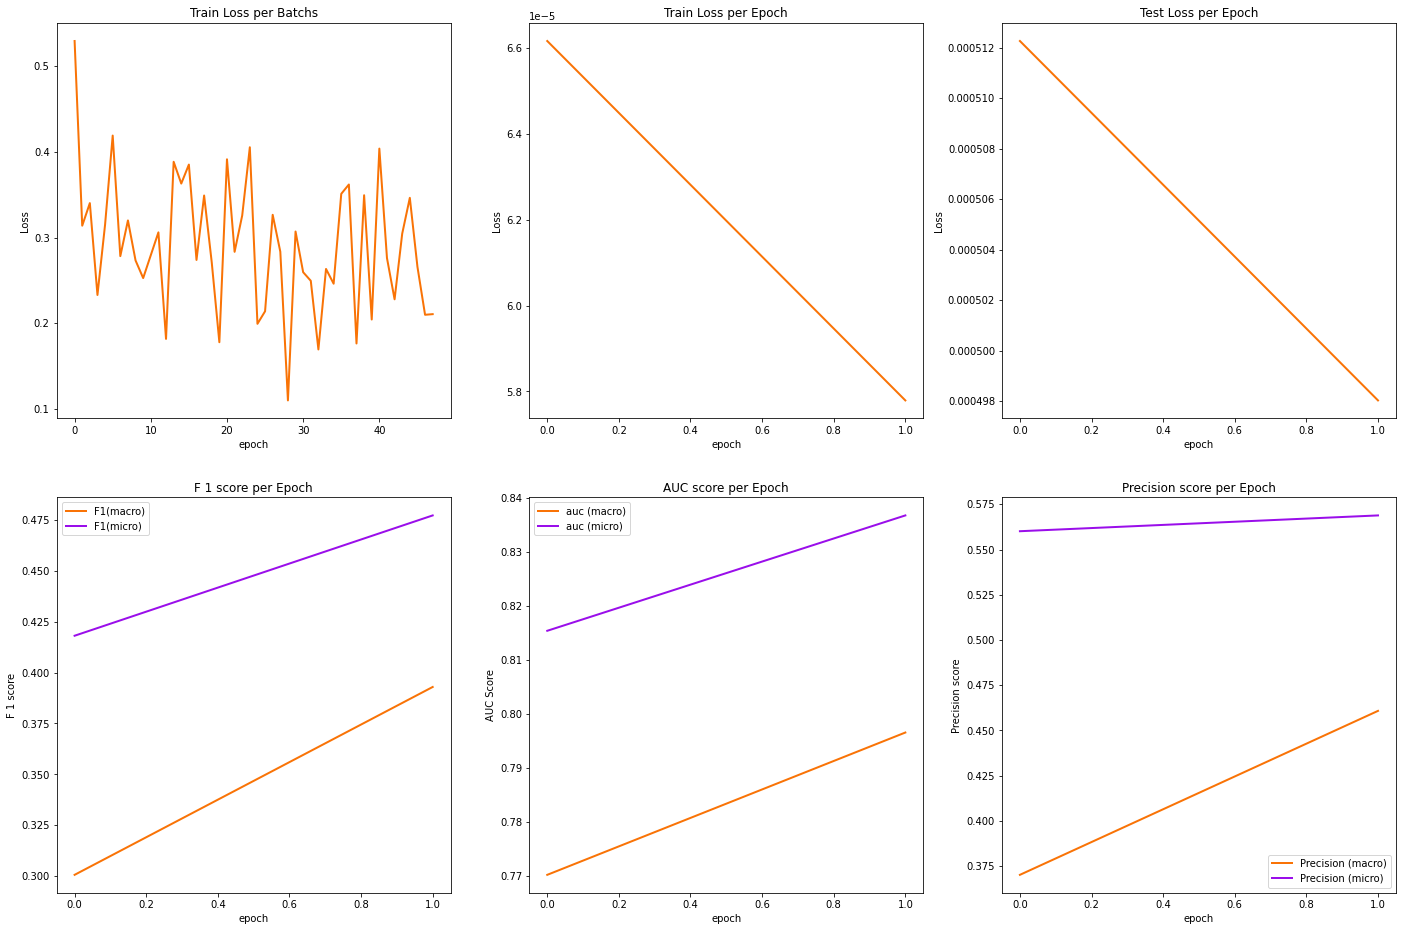

#########  Visulization End :##########
###############   Epoch 3: Training Start   #############
already deal with 600 data 	loss: 0.22693009674549103
already deal with 1200 data 	loss: 0.18220770359039307
already deal with 1800 data 	loss: 0.3167575001716614
already deal with 2400 data 	loss: 0.24412761628627777
already deal with 3000 data 	loss: 0.17280171811580658
already deal with 3600 data 	loss: 0.21684080362319946
already deal with 4200 data 	loss: 0.2591601014137268
already deal with 4800 data 	loss: 0.30531713366508484
already deal with 5400 data 	loss: 0.31076177954673767
already deal with 6000 data 	loss: 0.23085099458694458
already deal with 6600 data 	loss: 0.32412421703338623
already deal with 7200 data 	loss: 0.143692284822464
already deal with 7800 data 	loss: 0.22923493385314941
already deal with 8400 data 	loss: 0.2310003787279129
already deal with 9000 data 	loss: 0.40062597393989563
already deal with 9600 data 	loss: 0.22877947986125946
already deal with 10200 data

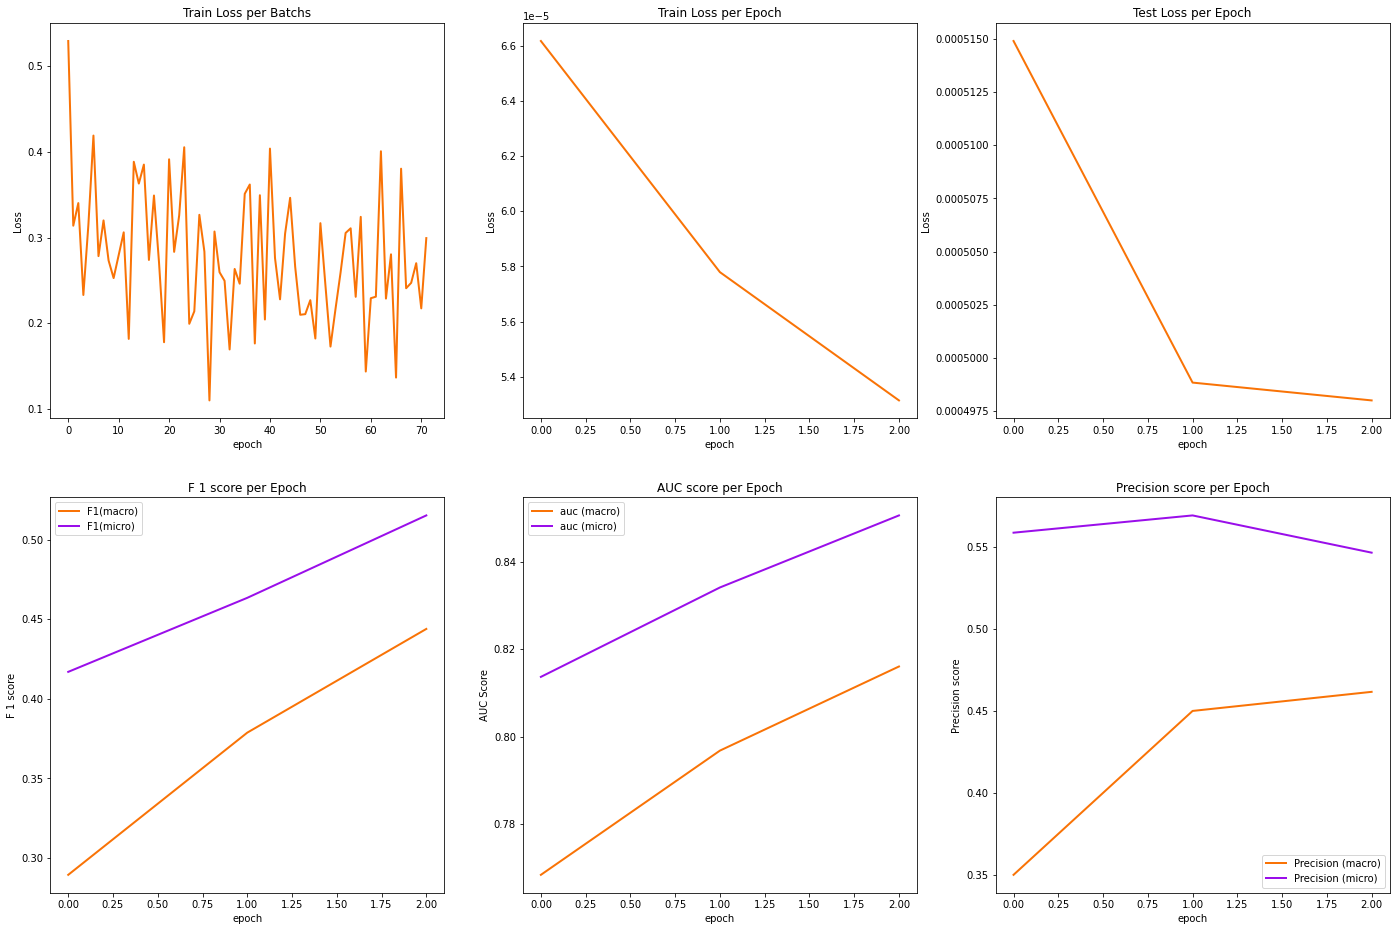

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

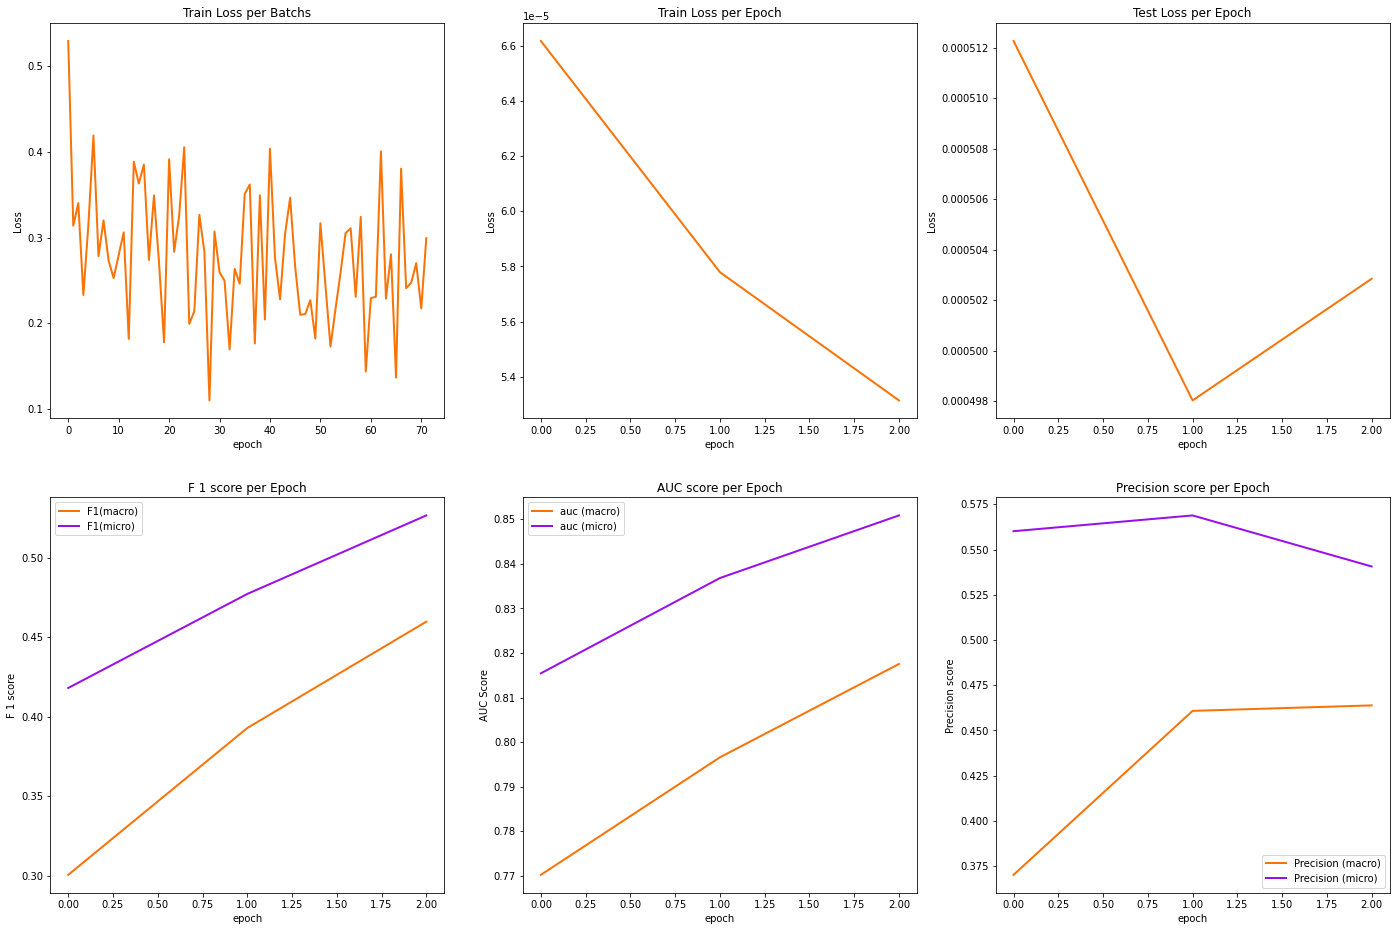

#########  Visulization End :##########
###############   Epoch 4: Training Start   #############
already deal with 600 data 	loss: 0.13661204278469086
already deal with 1200 data 	loss: 0.2793484032154083
already deal with 1800 data 	loss: 0.21860459446907043
already deal with 2400 data 	loss: 0.21819046139717102
already deal with 3000 data 	loss: 0.297215074300766
already deal with 3600 data 	loss: 0.3891661763191223
already deal with 4200 data 	loss: 0.17656993865966797
already deal with 4800 data 	loss: 0.19810141623020172
already deal with 5400 data 	loss: 0.17702046036720276
already deal with 6000 data 	loss: 0.27370673418045044
already deal with 6600 data 	loss: 0.19731567800045013
already deal with 7200 data 	loss: 0.22278143465518951
already deal with 7800 data 	loss: 0.23783595860004425
already deal with 8400 data 	loss: 0.26679307222366333
already deal with 9000 data 	loss: 0.14449633657932281
already deal with 9600 data 	loss: 0.22465279698371887
already deal with 10200 dat

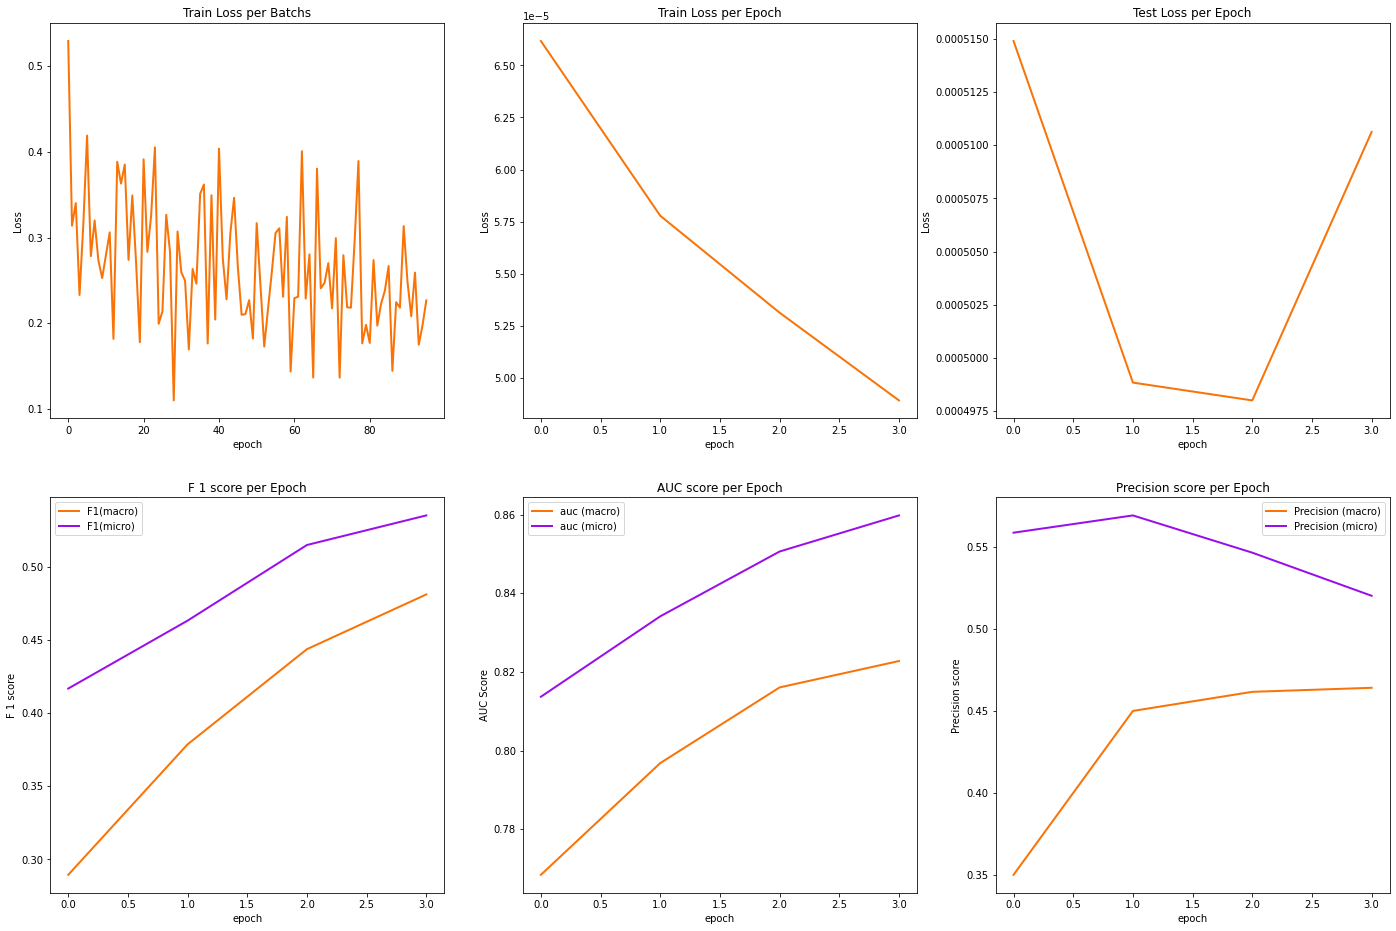

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

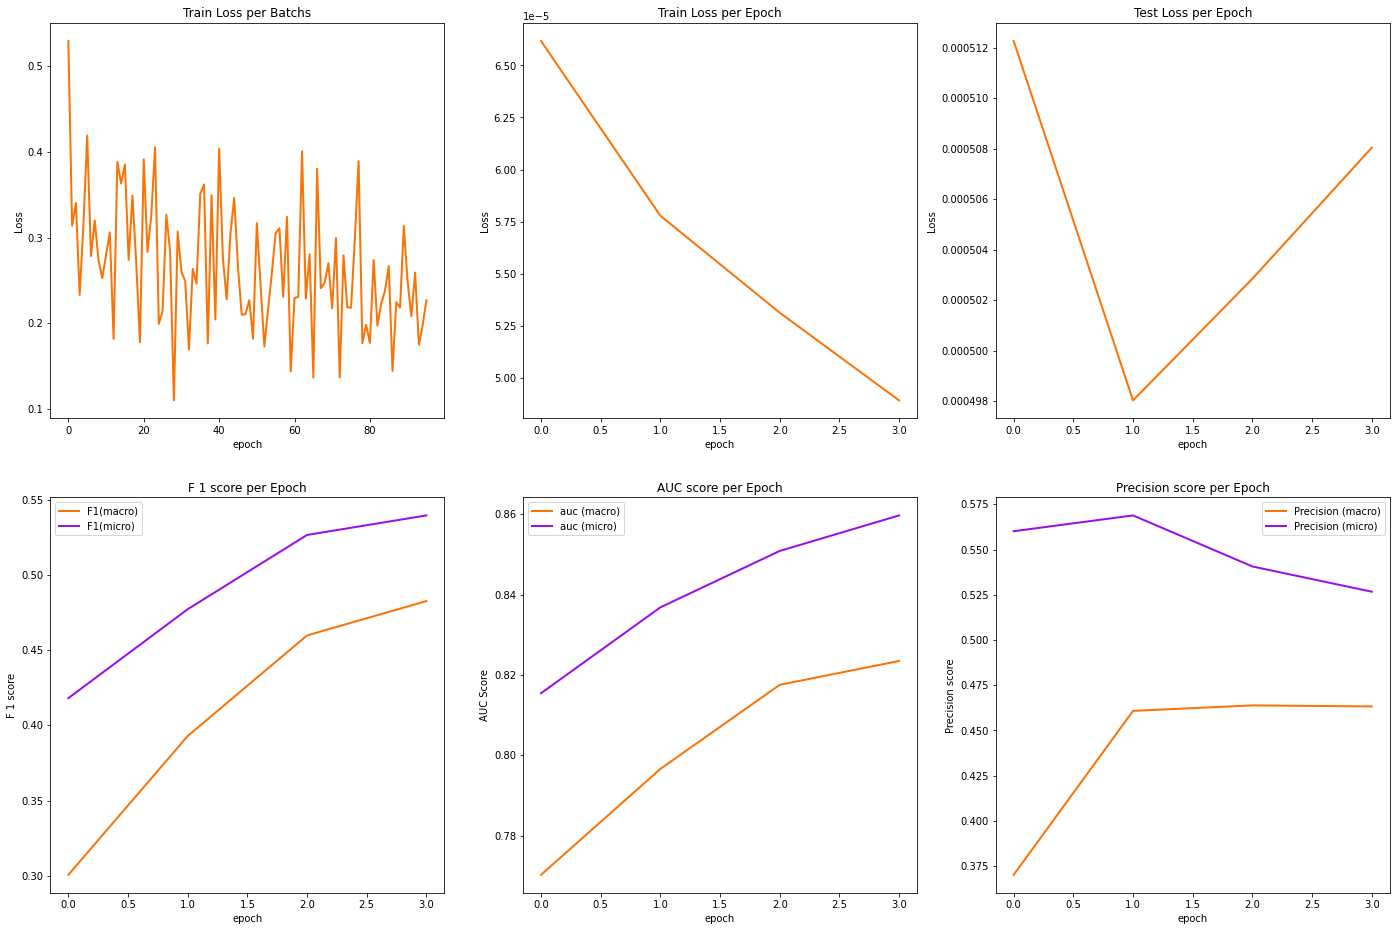

#########  Visulization End :##########
###############   Epoch 5: Training Start   #############
already deal with 600 data 	loss: 0.16138887405395508
already deal with 1200 data 	loss: 0.19193336367607117
already deal with 1800 data 	loss: 0.23060797154903412
already deal with 2400 data 	loss: 0.21256496012210846
already deal with 3000 data 	loss: 0.26495009660720825
already deal with 3600 data 	loss: 0.22559382021427155
already deal with 4200 data 	loss: 0.20079953968524933
already deal with 4800 data 	loss: 0.21022172272205353
already deal with 5400 data 	loss: 0.25456780195236206
already deal with 6000 data 	loss: 0.17293846607208252
already deal with 6600 data 	loss: 0.09570261836051941
already deal with 7200 data 	loss: 0.17818769812583923
already deal with 7800 data 	loss: 0.2249571830034256
already deal with 8400 data 	loss: 0.24953842163085938
already deal with 9000 data 	loss: 0.1896805465221405
already deal with 9600 data 	loss: 0.18807561695575714
already deal with 10200 d

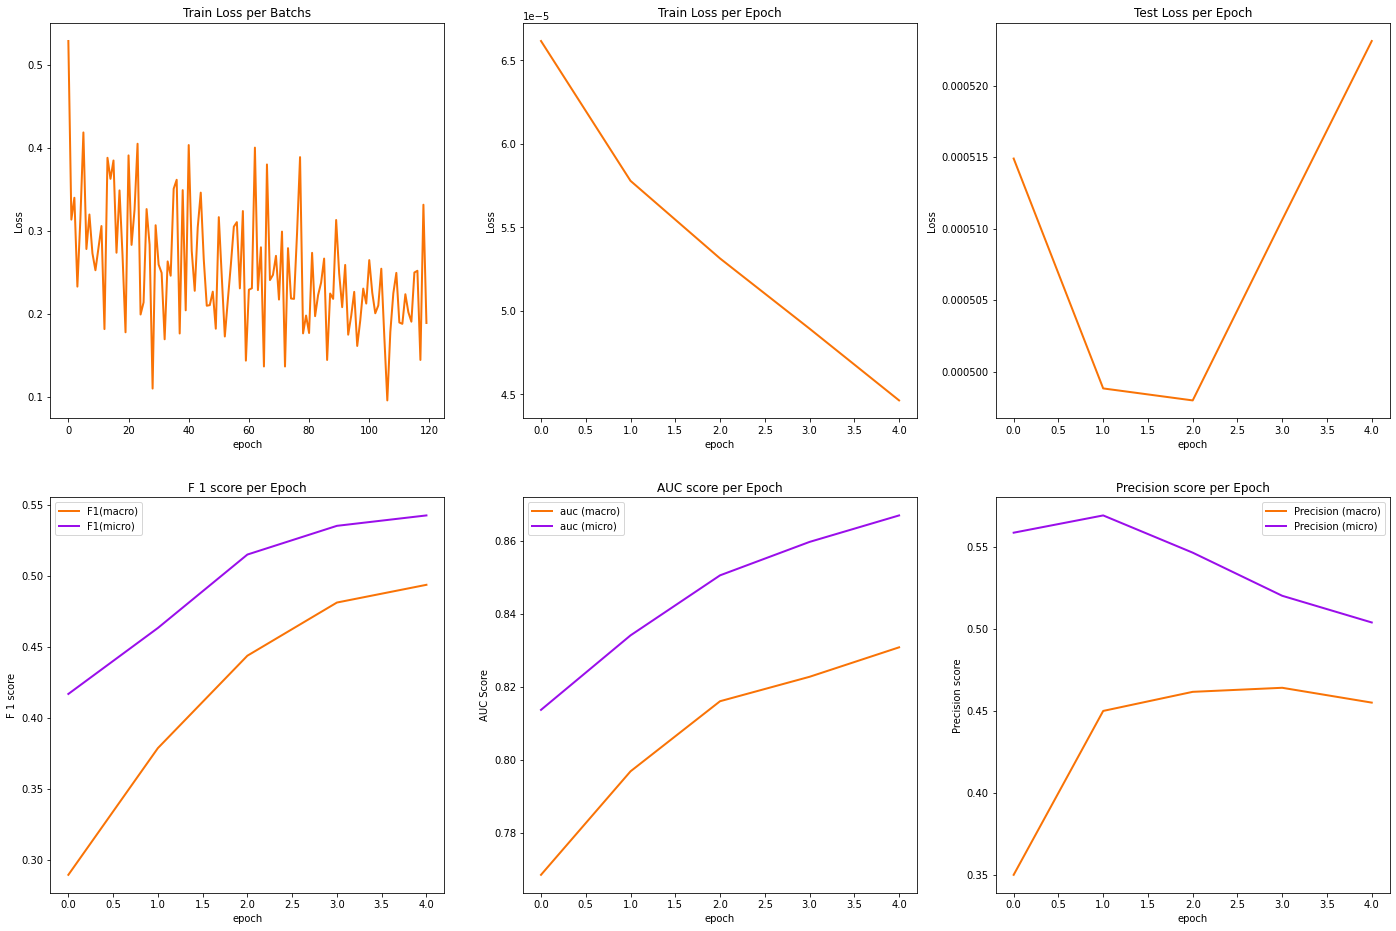

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

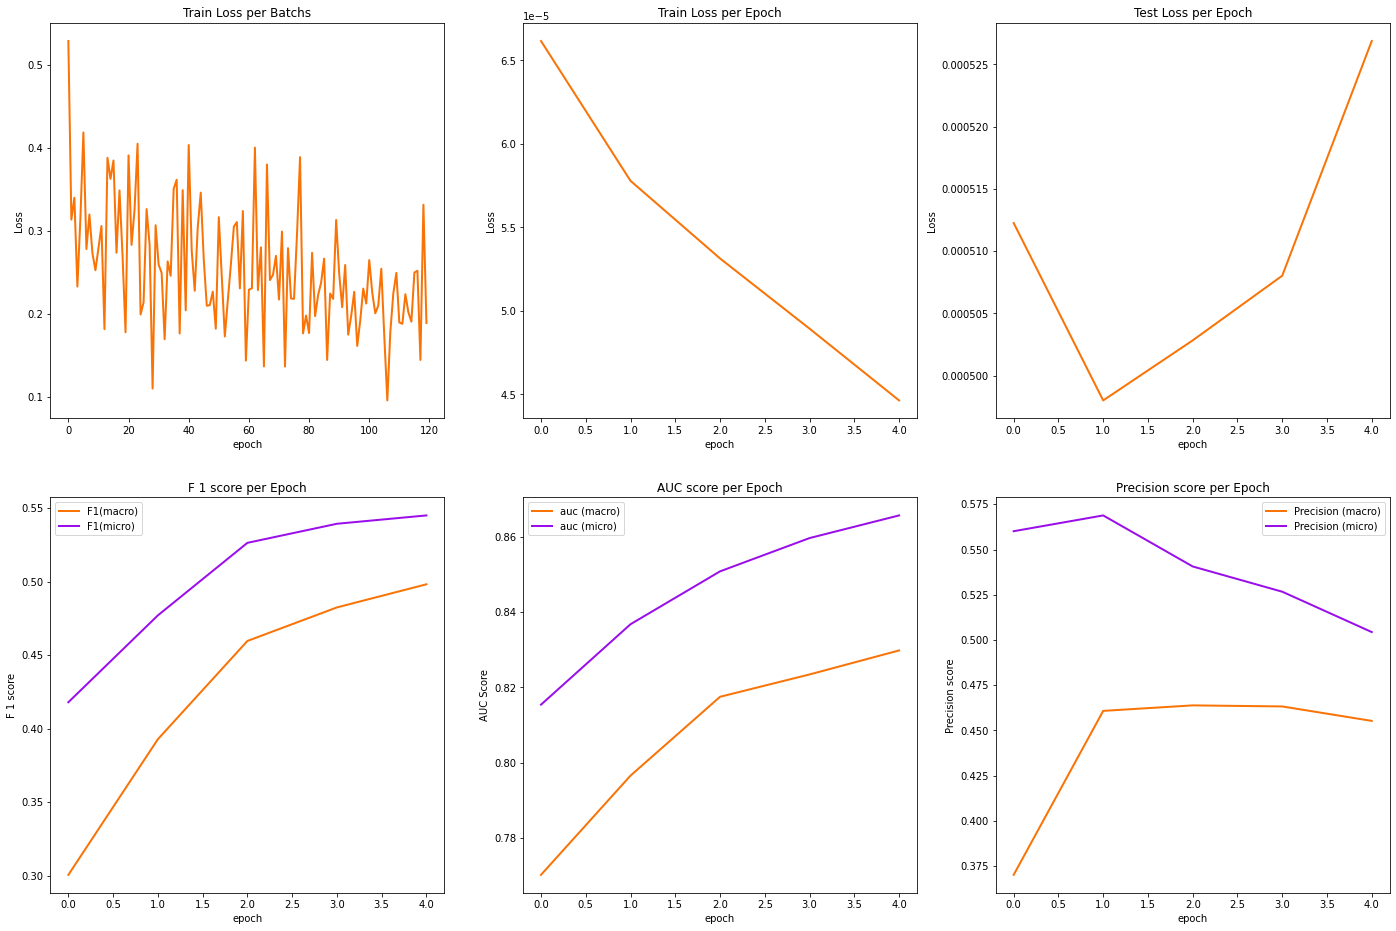

#########  Visulization End :##########
###############   Epoch 6: Training Start   #############
already deal with 600 data 	loss: 0.22381846606731415
already deal with 1200 data 	loss: 0.15930557250976562
already deal with 1800 data 	loss: 0.2232438176870346
already deal with 2400 data 	loss: 0.1935996264219284
already deal with 3000 data 	loss: 0.18221206963062286
already deal with 3600 data 	loss: 0.18883919715881348
already deal with 4200 data 	loss: 0.21678714454174042
already deal with 4800 data 	loss: 0.174839049577713
already deal with 5400 data 	loss: 0.17696058750152588
already deal with 6000 data 	loss: 0.17314854264259338
already deal with 6600 data 	loss: 0.1817425638437271
already deal with 7200 data 	loss: 0.28127482533454895
already deal with 7800 data 	loss: 0.2822137475013733
already deal with 8400 data 	loss: 0.24762314558029175
already deal with 9000 data 	loss: 0.37571558356285095
already deal with 9600 data 	loss: 0.23571786284446716
already deal with 10200 data 

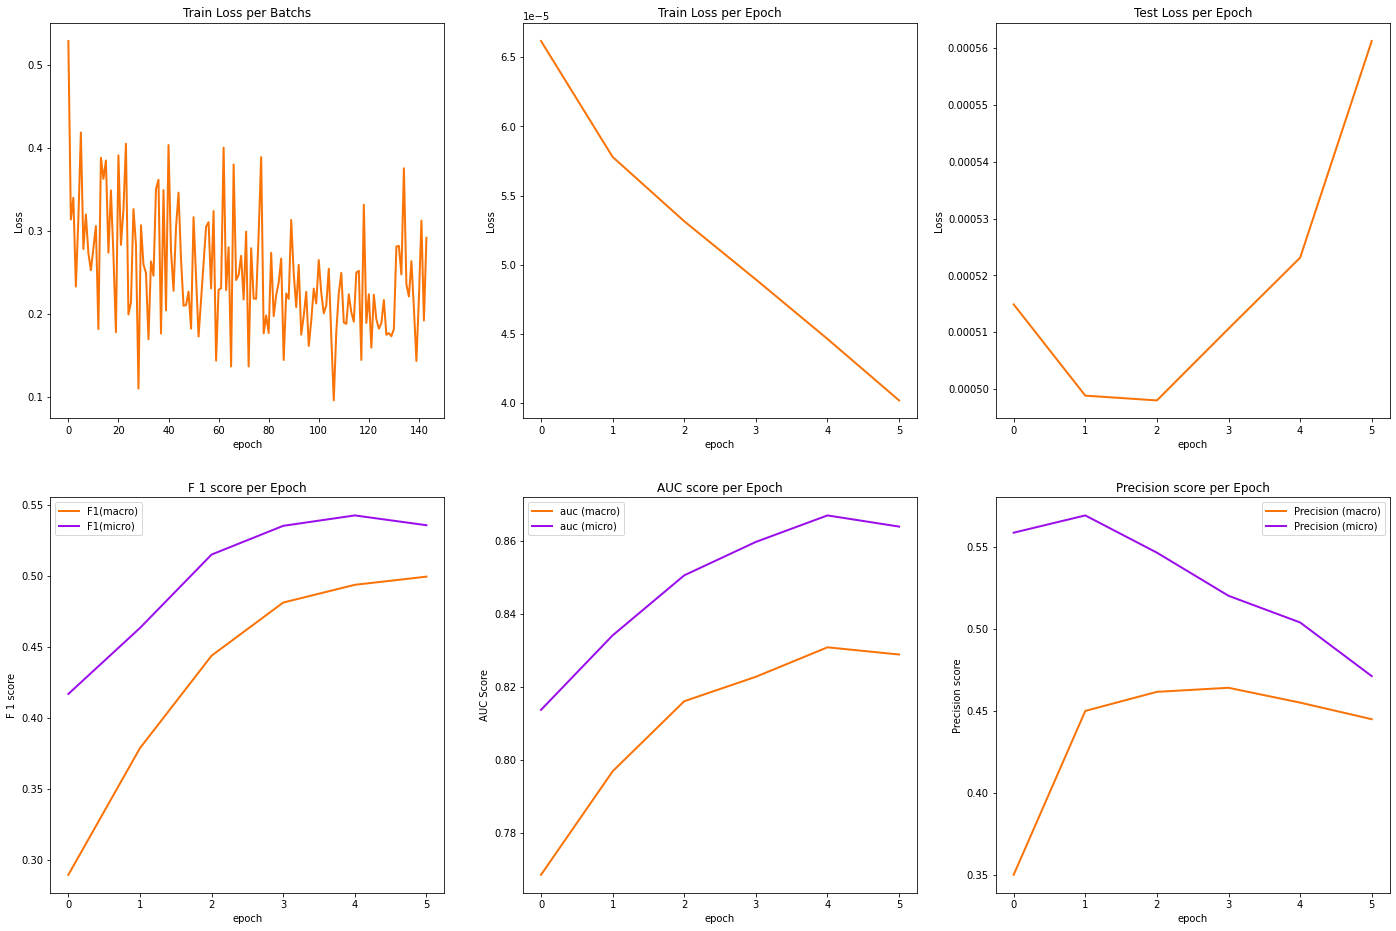

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

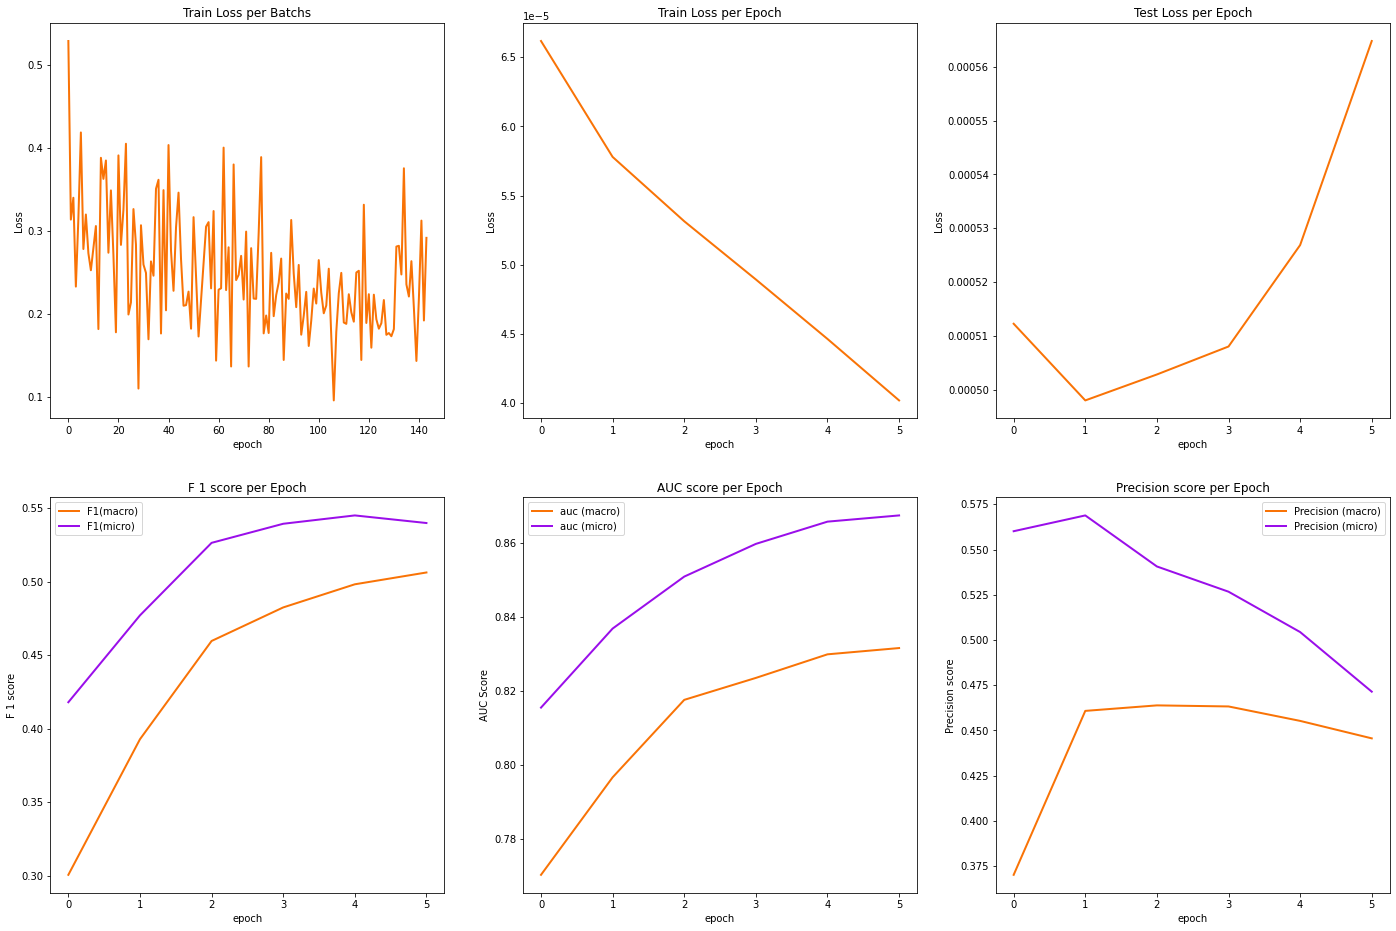

#########  Visulization End :##########
###############   Epoch 7: Training Start   #############
already deal with 600 data 	loss: 0.1510753482580185
already deal with 1200 data 	loss: 0.18162129819393158
already deal with 1800 data 	loss: 0.16390495002269745
already deal with 2400 data 	loss: 0.08809737861156464
already deal with 3000 data 	loss: 0.1511172205209732
already deal with 3600 data 	loss: 0.09342360496520996
already deal with 4200 data 	loss: 0.19637618958950043
already deal with 4800 data 	loss: 0.1901274472475052
already deal with 5400 data 	loss: 0.22165733575820923
already deal with 6000 data 	loss: 0.20093369483947754
already deal with 6600 data 	loss: 0.11328545212745667
already deal with 7200 data 	loss: 0.25093361735343933
already deal with 7800 data 	loss: 0.08383885771036148
already deal with 8400 data 	loss: 0.15523353219032288
already deal with 9000 data 	loss: 0.2573973834514618
already deal with 9600 data 	loss: 0.23137187957763672
already deal with 10200 dat

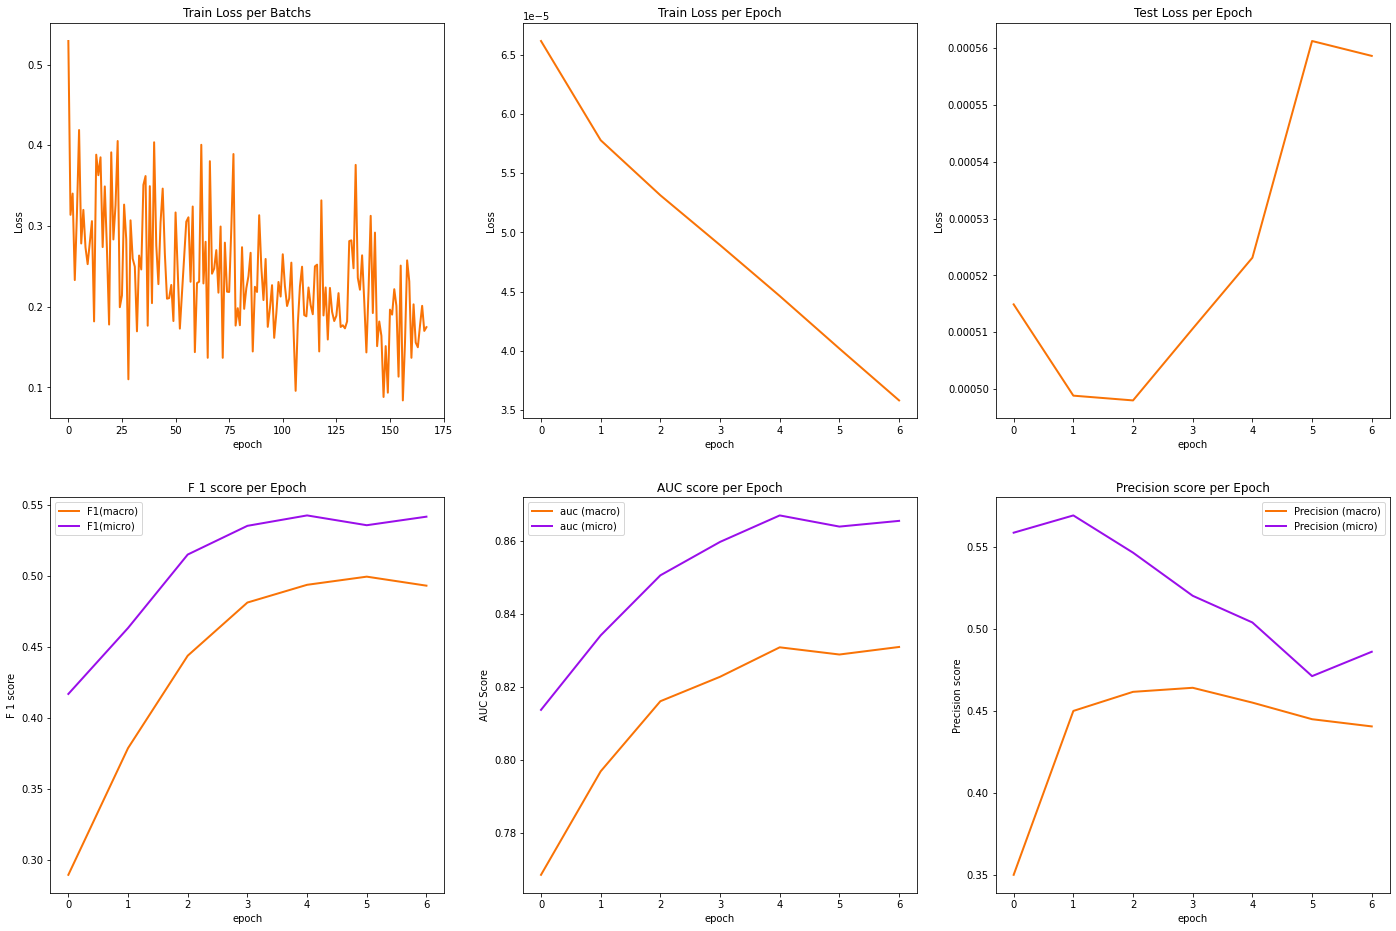

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

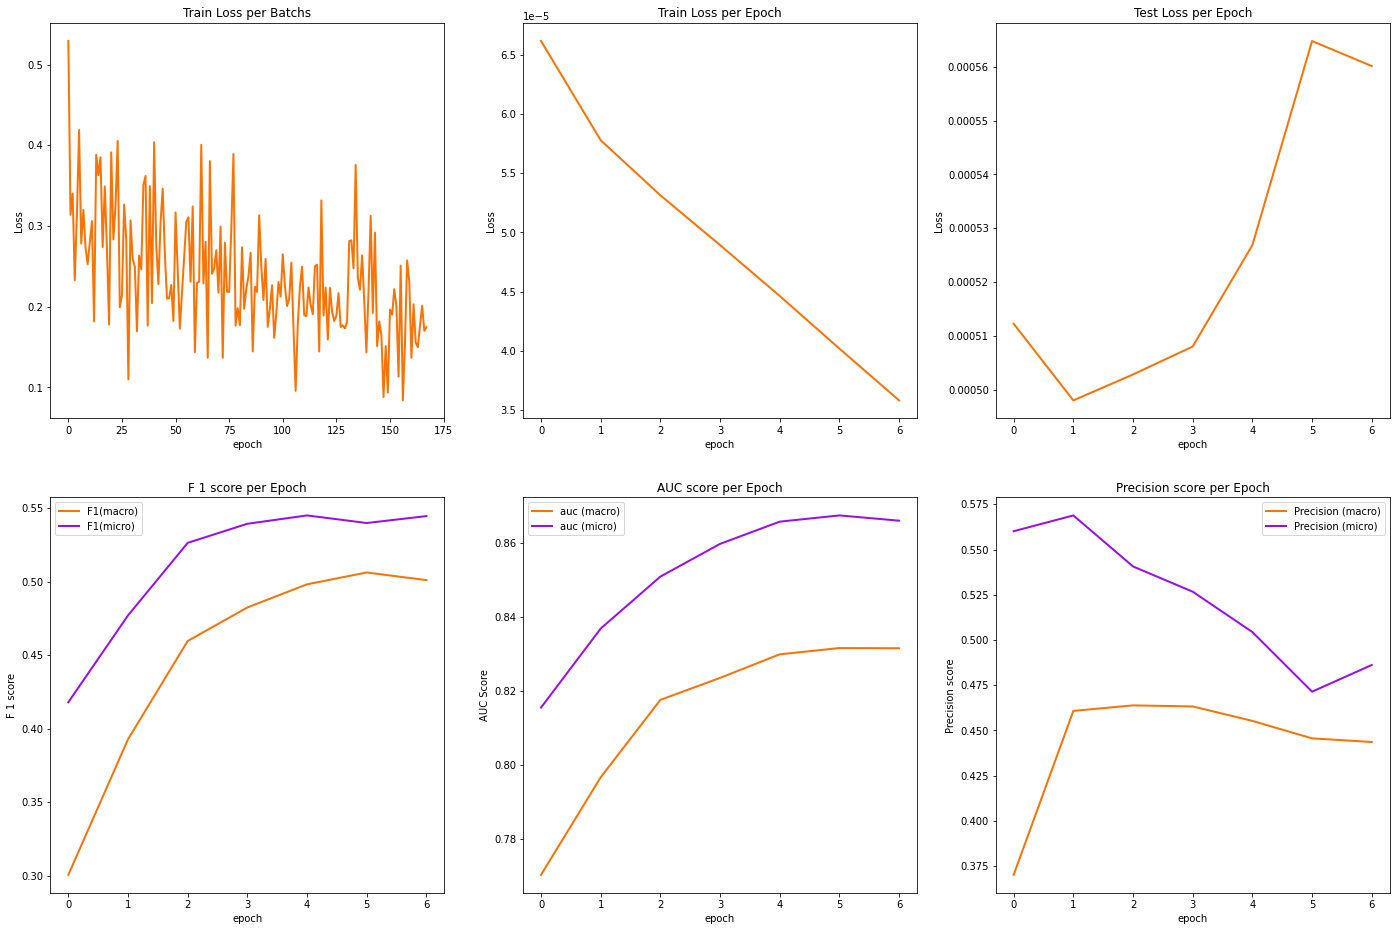

#########  Visulization End :##########
###############   Epoch 8: Training Start   #############
already deal with 600 data 	loss: 0.15370497107505798
already deal with 1200 data 	loss: 0.20597007870674133
already deal with 1800 data 	loss: 0.17802128195762634
already deal with 2400 data 	loss: 0.2039920538663864
already deal with 3000 data 	loss: 0.13361512124538422
already deal with 3600 data 	loss: 0.18353386223316193
already deal with 4200 data 	loss: 0.1404271274805069
already deal with 4800 data 	loss: 0.2458035796880722
already deal with 5400 data 	loss: 0.17216694355010986
already deal with 6000 data 	loss: 0.15446701645851135
already deal with 6600 data 	loss: 0.1924414336681366
already deal with 7200 data 	loss: 0.1143486276268959
already deal with 7800 data 	loss: 0.20170044898986816
already deal with 8400 data 	loss: 0.16562068462371826
already deal with 9000 data 	loss: 0.17132873833179474
already deal with 9600 data 	loss: 0.17101062834262848
already deal with 10200 data

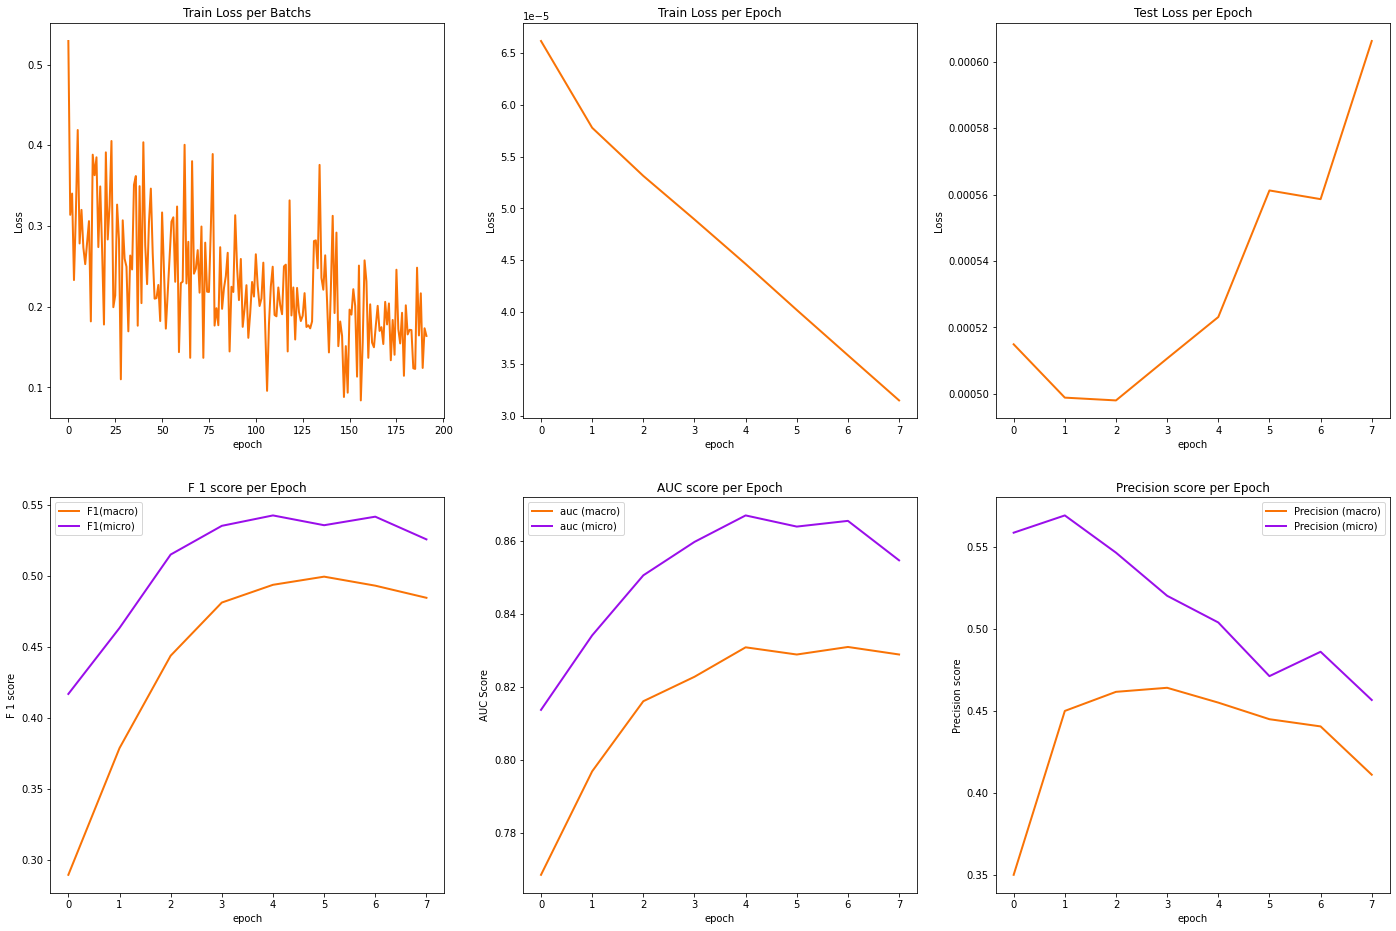

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

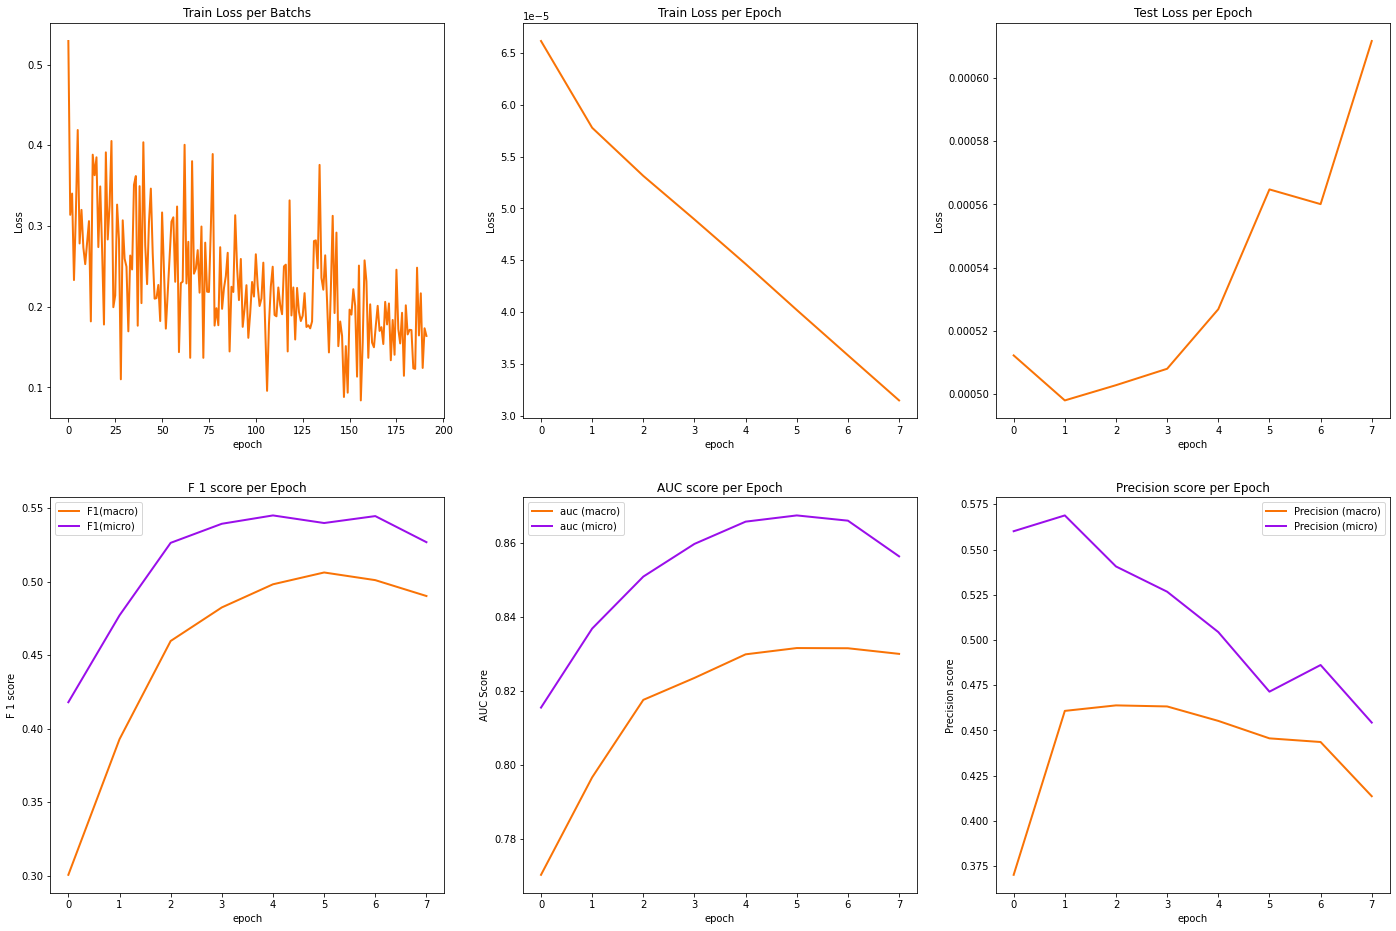

#########  Visulization End :##########
###############   Epoch 9: Training Start   #############
already deal with 600 data 	loss: 0.12322594970464706
already deal with 1200 data 	loss: 0.1603037565946579
already deal with 1800 data 	loss: 0.18894845247268677
already deal with 2400 data 	loss: 0.18546460568904877
already deal with 3000 data 	loss: 0.1529529094696045
already deal with 3600 data 	loss: 0.1892157346010208
already deal with 4200 data 	loss: 0.10108628869056702
already deal with 4800 data 	loss: 0.05768543481826782
already deal with 5400 data 	loss: 0.11007927358150482
already deal with 6000 data 	loss: 0.0854215994477272
already deal with 6600 data 	loss: 0.19312812387943268
already deal with 7200 data 	loss: 0.11020523309707642
already deal with 7800 data 	loss: 0.1829247772693634
already deal with 8400 data 	loss: 0.18281276524066925
already deal with 9000 data 	loss: 0.1074538454413414
already deal with 9600 data 	loss: 0.228505477309227
already deal with 10200 data 	l

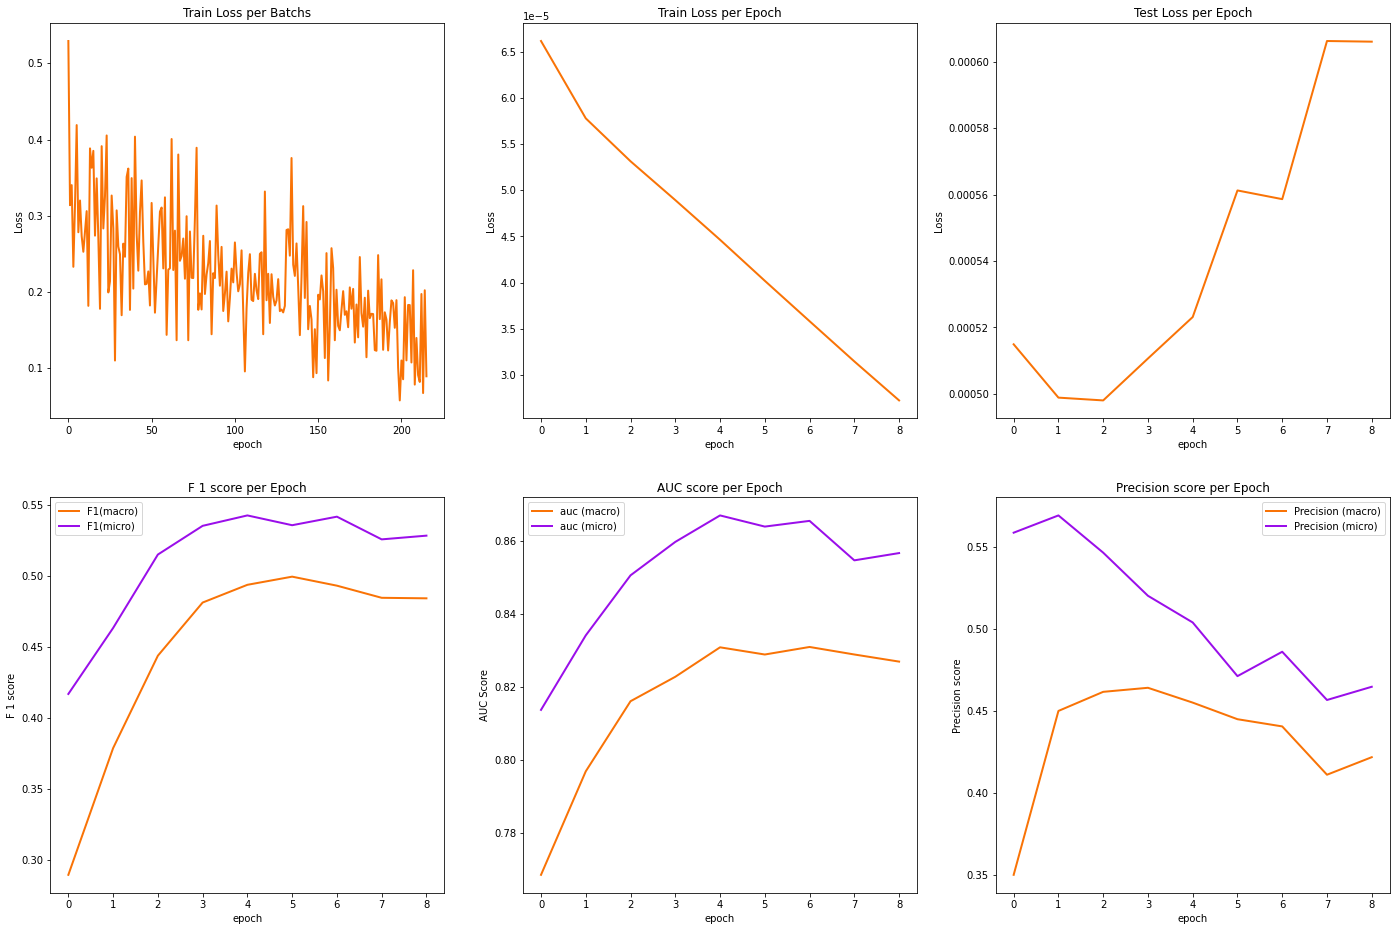

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

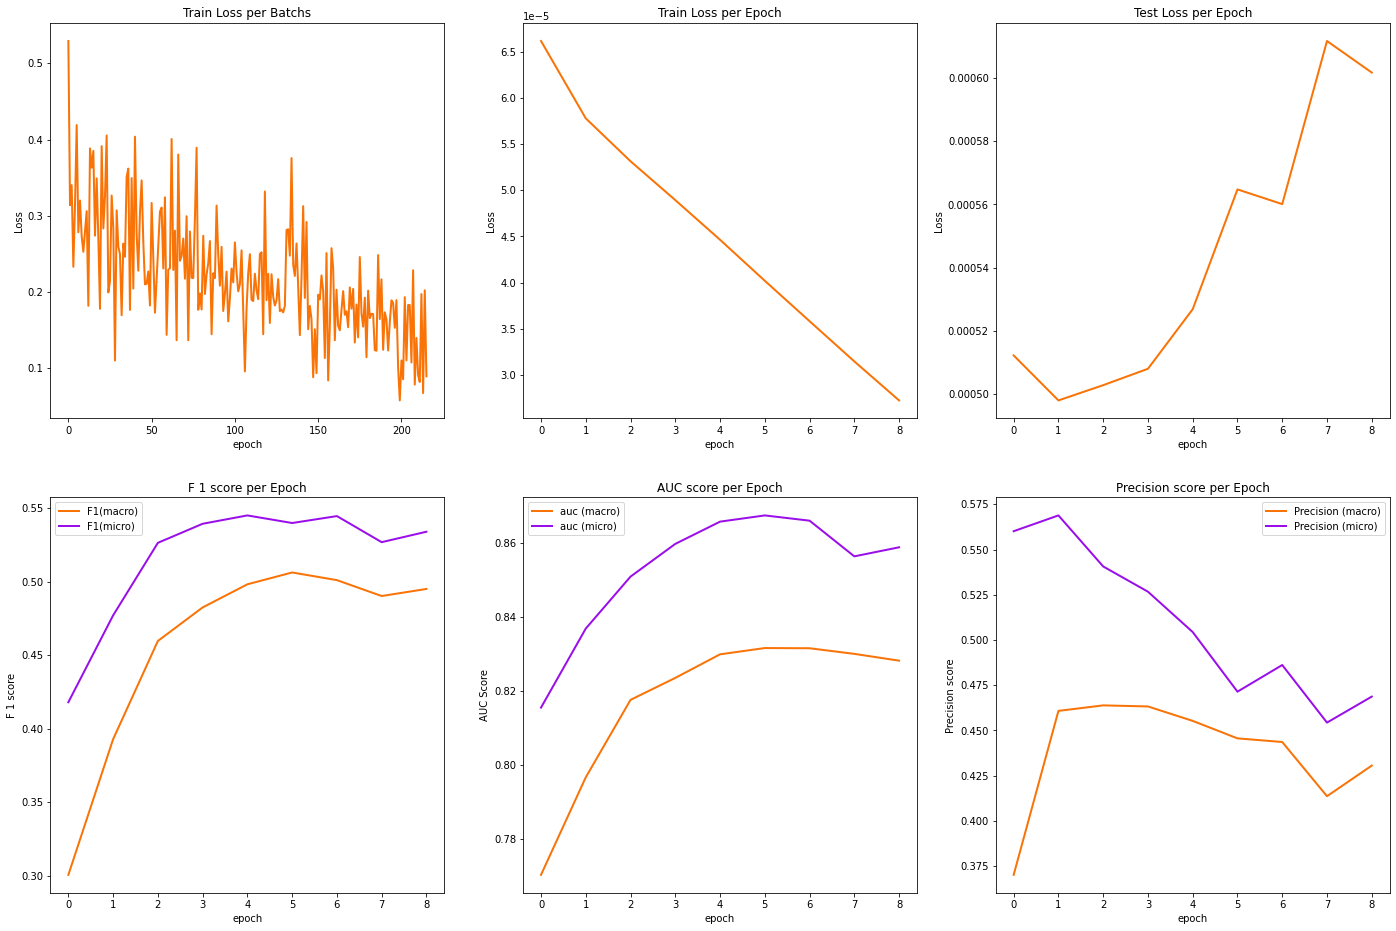

#########  Visulization End :##########
###############   Epoch 10: Training Start   #############
already deal with 600 data 	loss: 0.2127523571252823
already deal with 1200 data 	loss: 0.04690307751297951
already deal with 1800 data 	loss: 0.09999240934848785
already deal with 2400 data 	loss: 0.17463475465774536
already deal with 3000 data 	loss: 0.09605798125267029
already deal with 3600 data 	loss: 0.046665020287036896
already deal with 4200 data 	loss: 0.1728464812040329
already deal with 4800 data 	loss: 0.14647026360034943
already deal with 5400 data 	loss: 0.26027777791023254
already deal with 6000 data 	loss: 0.09475551545619965
already deal with 6600 data 	loss: 0.127275750041008
already deal with 7200 data 	loss: 0.17426851391792297
already deal with 7800 data 	loss: 0.059540655463933945
already deal with 8400 data 	loss: 0.14141014218330383
already deal with 9000 data 	loss: 0.12868234515190125
already deal with 9600 data 	loss: 0.10406932979822159
already deal with 10200 

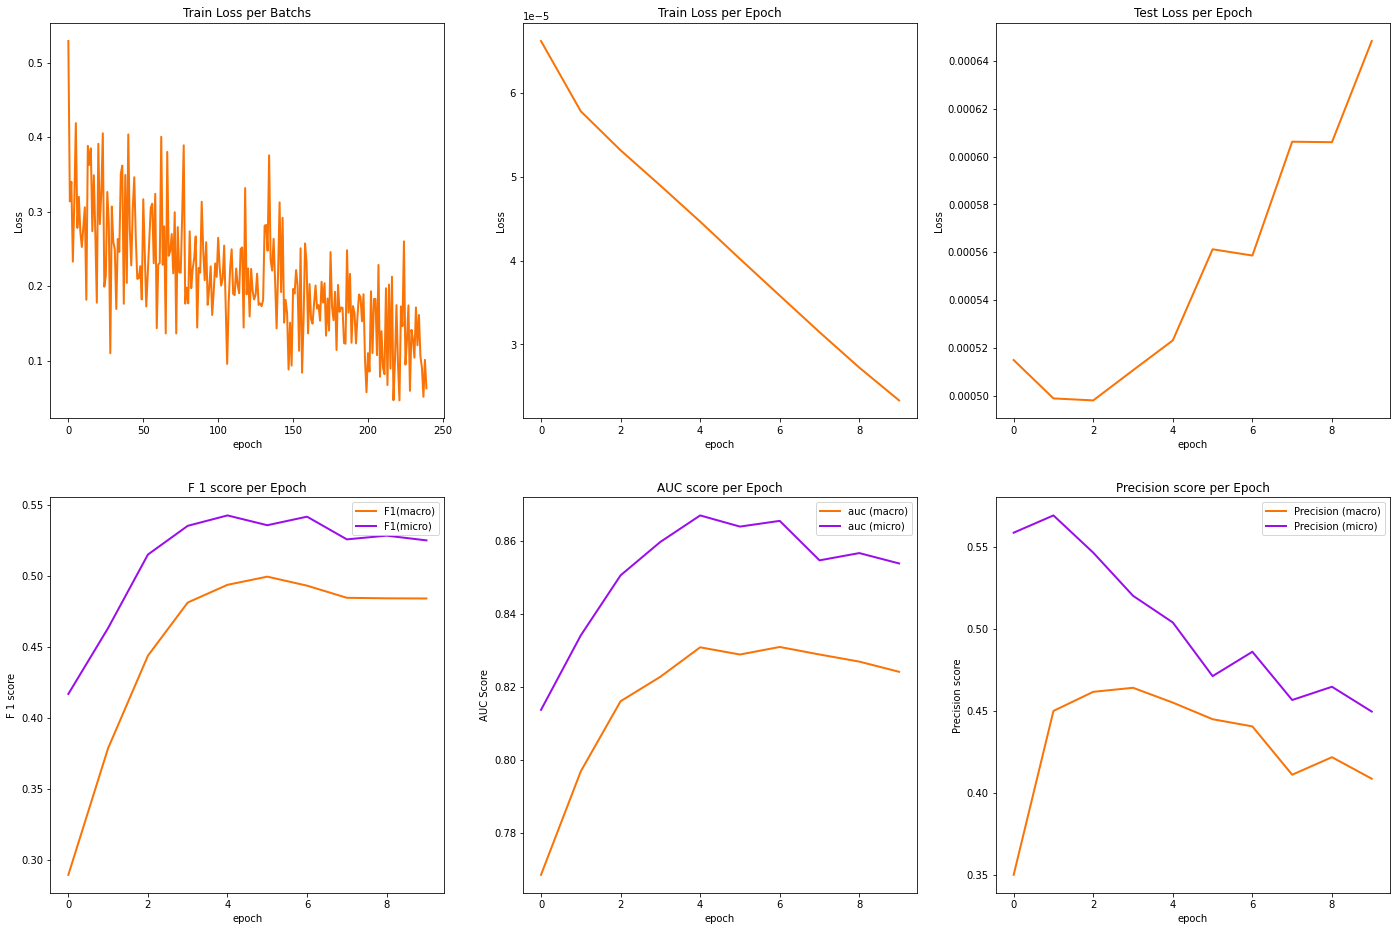

{'train_loss_batch': [0.5292260646820068, 0.31381547451019287, 0.34017214179039, 0.2329825460910797, 0.31507790088653564, 0.41893407702445984, 0.2783214747905731, 0.31995630264282227, 0.2732473313808441, 0.25270718336105347, 0.27938953042030334, 0.30604127049446106, 0.18175660073757172, 0.38835835456848145, 0.3629433810710907, 0.3851070702075958, 0.2738592028617859, 0.3490184247493744, 0.2710331678390503, 0.17787490785121918, 0.3912481367588043, 0.28329628705978394, 0.32576465606689453, 0.4053053855895996, 0.19935233891010284, 0.21396228671073914, 0.32650575041770935, 0.28349024057388306, 0.11000818014144897, 0.30701103806495667, 0.2595480680465698, 0.24953024089336395, 0.16944493353366852, 0.26336491107940674, 0.2461409568786621, 0.3509643077850342, 0.3618558645248413, 0.17641885578632355, 0.3493410348892212, 0.20438331365585327, 0.4037317633628845, 0.27611157298088074, 0.22792308032512665, 0.3045106530189514, 0.346330463886261, 0.265868216753006, 0.20989902317523956, 0.21063575148582

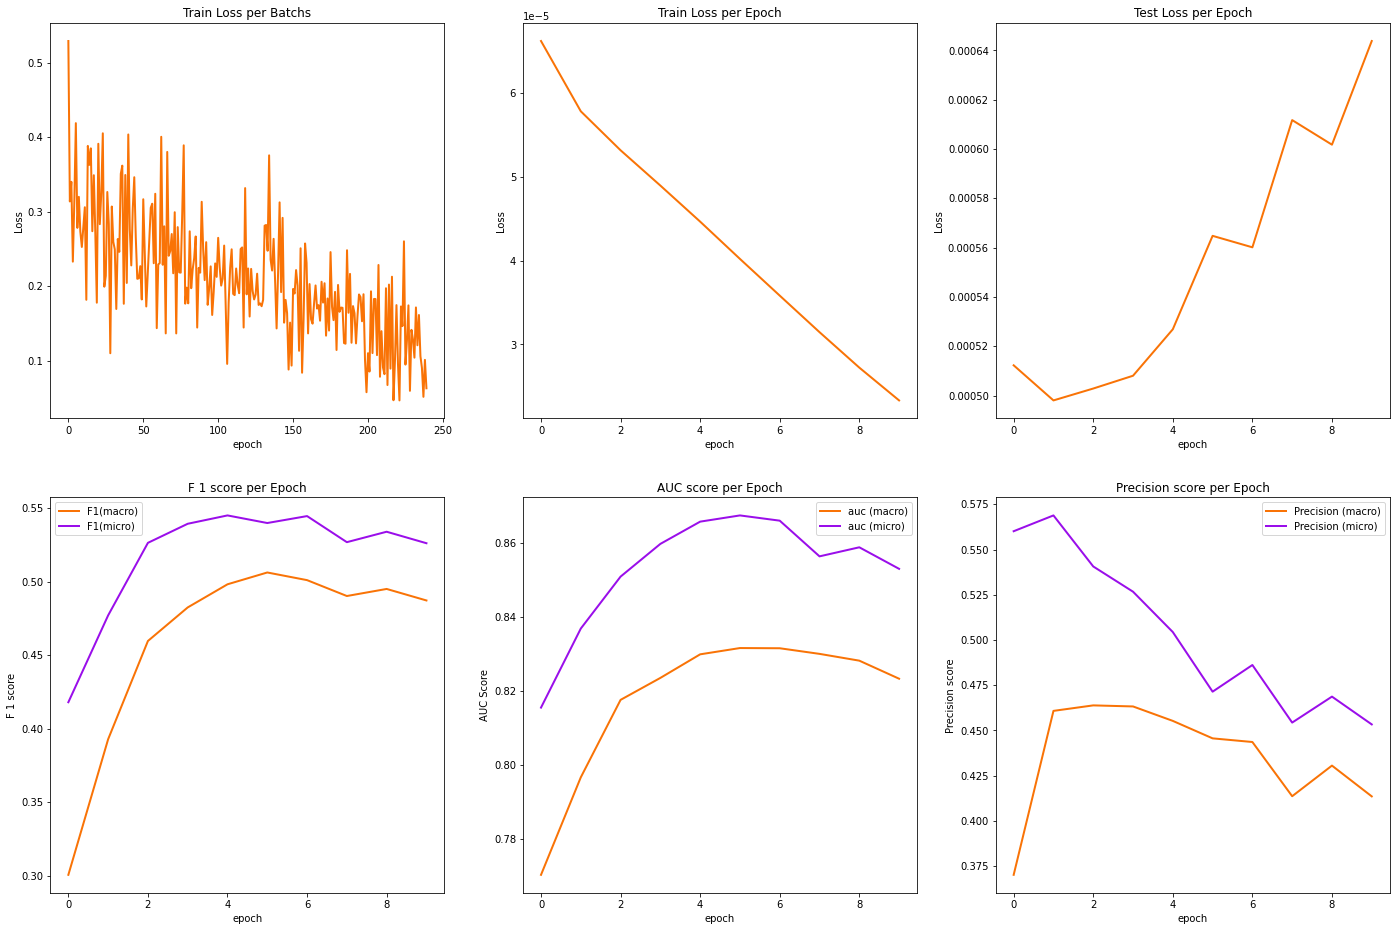

#########  Visulization End :##########
###############   Epoch 11: Training Start   #############
already deal with 600 data 	loss: 0.09730133414268494
already deal with 1200 data 	loss: 0.12011635303497314
already deal with 1800 data 	loss: 0.055478960275650024


KeyboardInterrupt: ignored

In [31]:
# 正式开始训练
result_loss = {'train_loss_batch':[],'train_loss_epoch':[],
               'test_loss_epoch':[],'test_macro_f1':[],'test_macro_recall':[],
               'test_macro_precision':[],'test_micro_f1':[],'test_micro_recall':[],
               'test_micro_precision':[],'test_macro_auc':[],'test_micro_auc':[]}
result_pro_loss = {'train_loss_batch':[],'train_loss_epoch':[],
               'test_loss_epoch':[],'test_macro_f1':[],'test_macro_recall':[],
               'test_macro_precision':[],'test_micro_f1':[],'test_micro_recall':[],
               'test_micro_precision':[],'test_macro_auc':[],'test_micro_auc':[]}

auc_macro_max  = 0  # 初始化最小的验证损失函数
for epoch in range(start_epochs, n_epochs+1):
  key = 0  # 用于提示合适保存图片
  test_targets = []
  test_outputs = []
  test_pro_targets = []
  test_pro_outputs = []
  train_loss = 0
  test_loss = 0
  train_pro_loss = 0
  test_pro_loss = 0
  ######################    
   # Train the model #
  ######################
  process_num = 0  
  model.train()
  print('###############   Epoch {}: Training Start   #############'.format(epoch))
  for batch_idx, data in enumerate(train_iter):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)  

    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
    # 记录信息
    process_num += batch_size
    if process_num % (600) == 0:  ############## 这里可以调
      print('already deal with '+ str(process_num)+' data','\tloss:',loss.item())
      result_loss['train_loss_batch'].append(loss.item())
      result_pro_loss['train_loss_batch'].append(loss.item())
  train_loss = train_loss/len(train_iter)  # 计算平均训练损失
  result_loss['train_loss_epoch'].append(train_loss) # 放到记录字典里
  result_pro_loss['train_loss_epoch'].append(train_loss) # 放到记录字典里
  print('Epoch {}: Training End'.format(epoch))

  ######################    
  # validate the model #
  ######################
  model.eval()
  with torch.no_grad():
    # 在 测试集上跑一遍
    for batch_idx, data in enumerate(test_iter, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_loss))
      test_targets.extend(targets.cpu().detach().numpy())
      test_outputs.extend(outputs.cpu().detach().numpy())
    test_loss = test_loss / len(test_iter)
    result_loss['test_loss_epoch'].append(test_loss)
    print('Epoch {}: Validation End'.format(epoch))
    # 打印一下 三个损失函数 
    print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Test Loss: {:.6f}'.format(epoch, train_loss,test_loss))
  
  with torch.no_grad():
    # 在 测试集上跑一遍
    for batch_idx, data in enumerate(test_pro_iter, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      test_pro_loss = test_pro_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_pro_loss))
      test_pro_targets.extend(targets.cpu().detach().numpy())
      test_pro_outputs.extend(outputs.cpu().detach().numpy())
    test_pro_loss = test_pro_loss / len(test_iter)
    result_pro_loss['test_loss_epoch'].append(test_pro_loss)
    print('Epoch {}: Validation End'.format(epoch))
    # 打印一下 三个损失函数 
    print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Test Loss: {:.6f}'.format(epoch, train_loss,test_pro_loss))

  #####################################
  ######### 记录结果, 保存模型  #########
  #####################################
  test_performence = epoch_perform(np.array(test_targets),np.array(test_outputs)) # 得到模型在test集合上的表现
  result_loss['test_macro_f1'].append(test_performence['f1_macro'])
  result_loss['test_micro_f1'].append(test_performence['f1_micro'])
  result_loss['test_macro_recall'].append(test_performence['rec_macro'])
  result_loss['test_micro_recall'].append(test_performence['rec_micro'])
  result_loss['test_macro_precision'].append(test_performence['prec_macro'])
  result_loss['test_micro_precision'].append(test_performence['prec_micro'])
  result_loss['test_macro_auc'].append(test_performence['auc_macro'])
  result_loss['test_micro_auc'].append(test_performence['auc_micro'])

  test_pro_performence = epoch_perform(np.array(test_pro_targets),np.array(test_pro_outputs)) # 得到模型在test集合上的表现
  result_pro_loss['test_macro_f1'].append(test_pro_performence['f1_macro'])
  result_pro_loss['test_micro_f1'].append(test_pro_performence['f1_micro'])
  result_pro_loss['test_macro_recall'].append(test_pro_performence['rec_macro'])
  result_pro_loss['test_micro_recall'].append(test_pro_performence['rec_micro'])
  result_pro_loss['test_macro_precision'].append(test_pro_performence['prec_macro'])
  result_pro_loss['test_micro_precision'].append(test_pro_performence['prec_micro'])
  result_pro_loss['test_macro_auc'].append(test_pro_performence['auc_macro'])
  result_pro_loss['test_micro_auc'].append(test_pro_performence['auc_micro'])

  # 下面要保存模型
  checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'test_outputs':np.array(test_outputs),
            'test_targets':np.array(test_targets),
            'test_pro_outputs':np.array(test_pro_outputs),
            'test_pro_targets':np.array(test_pro_targets),
            'loss':result_loss,
            'loss_pro':result_pro_loss,
            'test_performence':test_performence,
            'test_pro_performence':test_pro_performence}

  if result_loss['test_macro_auc'][-1] > auc_macro_max:
    auc_macro_max = result_loss['test_macro_auc'][-1]
    if epoch > 3 :  # 这里是真的要保存了  # 记着设置保存条件
      # 保存模型
      save_ckp(checkpoint, checkpoint_path+'/checkpoint_epoch_'+ str(epoch) + '.pt' )
    # 保存test , loss 字典
    #test_json = json.dumps(test_performence,sort_keys=False, indent=4, separators=(',', ': '))
    #loss_json = json.dumps(result_loss,sort_keys=False, indent=4, separators=(',', ': '))
    #f = open(checkpoint_path + '/test_performence_epoch_'+ str(epoch) +'.json', 'w')
    #f.write(test_json)
    #f = open(checkpoint_path + '/loss_epoch_'+ str(epoch) +'.json', 'w')
    #f.write(loss_json)

  #####################################
  ######### 可视化，打印  #########
  #####################################
  print('#########  Visulization Start :##########')
  print("Loss :")
  print(result_loss)
  draw_loss(result_loss,checkpoint_path,key)
  print(result_pro_loss)
  draw_loss(result_pro_loss,checkpoint_path,key)
  print('#########  Visulization End :##########')
  #print('test: ')
  #draw_pr_roc(test_performence,
  #            np.array(test_targets),np.array(test_outputs),   # np 优化
  #            checkpoint_path,epoch,'test',
  #            key)

In [ ]:
'''
first_outputs = 0
for batch_idx, data in enumerate(train_iter):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)  
'''    

In [ ]:
#my_bert = transformers.BertModel.from_pretrained('bert-base-uncased')
#my_bert.to(device)
first_outputs = 0
for batch_idx, data in enumerate(train_iter):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    #first_outputs = my_bert(ids[:,:512], mask[:,:512], token_type_ids[:,:512])  
    break

In [ ]:
first_outputs[0].shape

In [ ]:
first_outputs[1].shape

# Evluation 

In [ ]:
import torch
checkpoint_fpath = "/content/drive/My Drive/MIMIC/BERT_FineTune/bert_base_heir/BERT3d+CNN/checkpoint_epoch_10.pt"
#load_ckp(checkpoint_fpath, model, optimizer)
# load check point
checkpoint = torch.load(checkpoint_fpath)
# initialize state_dict from checkpoint to model
#model.load_state_dict(checkpoint['state_dict'])
checkpoint['loss']

# Result + Data